# Plotting intersecting regulons

## Find intersecting DE regulons for each lineage and plot them below
- concept is to plot the top intersecting regulons between similar lineages of mouse and human. 
- Control:: Plot top 10 regulons per lineage within each species

    - Define only regulons which are regulated by homologous TFs in each species
    - Define (conserved) intersecting regulons: DE test for top 20 regulons per lineage in each species. 
    - Plot top regulons for each lineage in the same order and across each celltype. 
    - Plot also regulons that are not intersecting and thus species specific

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
from dask.diagnostics import ProgressBar
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
hu_lineages = {
# 'Erythroid':['HSPC_1','HSPC_2','MEMP','Early_Erythroid','Erythroid',],
# 'Macrophage':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Pre_Macrophage','Macrophage',],
# 'MK':['HSPC_1','HSPC_2','MEMP','MK']
'Macrophage_pre':['HSPC_1','HSPC_2','CMP','MOP','Promonocyte','Pre_Macrophage','Macrophage',],
#'Macrophage_post':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Pre_Macrophage','Macrophage',],
'Macrophage_post':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage',],
}

In [72]:
hu_lineages = {
# 'Erythroid':['HSPC_1','HSPC_2','MEMP','Early_Erythroid','Erythroid',],
# 'Macrophage_pre':['HSPC_1','HSPC_2','CMP','MOP','Promonocyte','Pre_Macrophage','Macrophage',],
'Macrophage_pre':['HSPC_1','Pre_Macrophage','Macrophage',],
'Macrophage_post':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage'],
'Macrophage_post_microglia':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage','Microglia'],
# 'MK':['HSPC_1','HSPC_2','MEMP','MK']
}

ages = {
'Macrophage_pre':['CS10', 'CS11'],
'Macrophage_post':['CS22', 'CS23', 'CS18', ],
'Macrophage_post_microglia':['CS22', 'CS23', 'CS14', 'CS18', 'CS15'], 
}

# Get differential GAMs between Pre and Post Monocyte dependent macrophages

In [4]:
adata_pre = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/mac_traj_pySCENIC_regulon/data/Macrophage_pre_hu_lineage_trial_dffimap.h5ad')

In [5]:
adata_pre

AnnData object with n_obs × n_vars = 1715 × 24287
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'celltype', 'species', 'species_donor', 'n_counts', 'restricted_celltype', 'n_genes', 'lr_batch', 'corr_concat', 'cell.labels', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'cell_cycle_score', 'cat_index', 'batch', 'leiden', 'num', 'corr_concat_num', 'keep', 'Regulon(ATF3(+))', 'Regulon(ATF5(+))', 'Regulon(CEBPA(+))', 'Regulon(CEBPD(+))', 'Regulon(CREB3L1(+))', 'Regulon(CREM(+))', 'Regulon(DDIT3(+))', 'Regulon(EGR1(+))', 'Regulon(EGR2(+))', 'Regulon(EGR3(+))', 'Regulon(ELF1(+))', 'Regulon(ELK1(+))', 'Regulon(ELK3(+))', 'Regulon(ERG(+))', 'Regulon(ETS2(+))', 'Regulon(ETV2(+))', 'Regulon(FLI1(+))', 'Regulon(FOS(+))', 'Regulon(FOSB(+))', 'Regulon(FOSL2(+))', 'Regulon(FOXF1(+))', 'Regulon(FOXO3(+))', 'Regulon(FOXP1(+))', 'Regulon(FOXP2(+))', 'Regulon(GATA1(+))', 'Regulon(GATA2(+))', 'Regulon(GATA3(+))', 'Regulon(HOXB6(

In [6]:
adata_post = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/mac_traj_pySCENIC_regulon/data/Macrophage_post_hu_lineage_trial_dffimap.h5ad')

In [7]:
adata_hu_raw = sc.read('./data/hu_diff_regulon_aucell.h5ad')

In [8]:
adata_hu_raw.obs['mono_independent'] = 'Unkown'
adata_hu_raw.obs.loc[adata_hu_raw.obs.index.isin(adata_pre.obs.index),'mono_independent'] = True
adata_hu_raw.obs.loc[adata_hu_raw.obs.index.isin(adata_post.obs.index),'mono_independent'] = False
adata = adata_hu_raw[~adata_hu_raw.obs['mono_independent'].isin(['Unkown'])]
adata.obs.groupby('mono_independent').count()

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(NR2F2(+)),Regulon(REL(+)),Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+))
mono_independent,,,,,,,,,,,,,,,,,,,,,
False,0,0,2657,0,0,2657,2657,2657,0,2657,...,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657
True,0,0,1715,0,0,1715,1715,1715,0,1715,...,1715,1715,1715,1715,1715,1715,1715,1715,1715,1715


In [9]:
adata.var

""
Regulon
ATF3(+)
ATF5(+)
CEBPA(+)
CEBPD(+)
CREB3L1(+)
...
SOX4(+)
SPI1(+)
STAT2(+)


# Just HSPC1

In [117]:
adata.obs.groupby('mono_independent').count()

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(NR2F2(+)),Regulon(REL(+)),Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+))
mono_independent,,,,,,,,,,,,,,,,,,,,,
False,0,0,2657,0,0,2657,2657,2657,0,2657,...,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657
True,0,0,1715,0,0,1715,1715,1715,0,1715,...,1715,1715,1715,1715,1715,1715,1715,1715,1715,1715


Trying to set attribute `.obs` of view, copying.


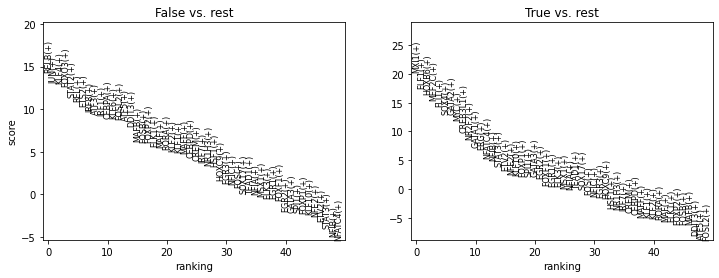

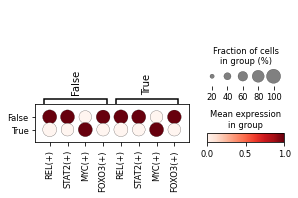

In [125]:
# DE

adata = adata[adata.obs['cell.labels'].isin(['HSPC_1'])]
spot_var = 'mono_independent'
adata.obs['mono_independent'] = adata.obs['mono_independent'].astype('category')
sc.tl.rank_genes_groups(adata, spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name ="./Differential_regulon.csv"
DE.to_csv(DE_name)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(14, 'p_val')).reset_index(drop=True)
marker_df = marker_df.groupby('cluster').apply(lambda grp: grp.nlargest(4, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata
markers = markers
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_gastrula.pdf')) # title=i

In [127]:
markers

{'False': ['REL(+)', 'STAT2(+)', 'MYC(+)', 'FOXO3(+)'],
 'True': ['REL(+)', 'STAT2(+)', 'MYC(+)', 'FOXO3(+)']}

In [136]:
markers = {
    'Common' : ["SPI1(+)"],
    'Mono_dependent': ['REL(+)', 'STAT2(+)'],
 'Mono_independent': [ 'MYC(+)', 'FOXO3(+)']}

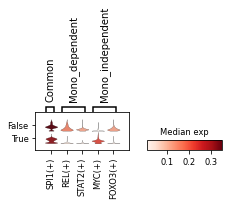

In [138]:
markers = {
    'Common' : ["SPI1(+)"],
    'Mono_dependent': ['REL(+)', 'STAT2(+)'],
 'Mono_independent': [ 'MYC(+)', 'FOXO3(+)']}
sc.pl.stacked_violin(adata ,var_names= markers, groupby='mono_independent',  log=False, use_raw=None, num_categories=7, title=None, colorbar_title='Median exp', figsize=None, dendrogram=False, gene_symbols=None, var_group_positions=None, var_group_labels=None, standard_scale='var', var_group_rotation=None, layer=None, stripplot=False, jitter=False, size=1, scale='width', yticklabels=False, order=None, swap_axes=False, show=None, return_fig=False, row_palette=None, cmap='Reds', ax=None, vmin=None, vmax=None, vcenter=None, norm=None)

In [139]:
'SPI1(+)','REL(+)', 'STAT2(+)',''

('SPI1(+)', 'REL(+)', 'STAT2(+)', '')

In [140]:
concat

,cluster,gene,p_val,logfc
0,False,RELB(+),2.235264e-46,2.001913
1,False,JUN(+),3.772109e-39,1.959294
2,False,KLF4(+),4.023875e-39,1.716291
3,False,FOXO3(+),1.136257e-36,1.461496
4,False,STAT2(+),5.106868e-30,1.345459
...,...,...,...,...
119,True,STAT2(+),5.106868e-30,-1.345459
120,True,FOXO3(+),1.136257e-36,-1.461496
121,True,KLF4(+),4.023875e-39,-1.716291
122,True,JUN(+),3.772109e-39,-1.959294


In [141]:
adata = adata_hu_raw[~adata_hu_raw.obs['mono_independent'].isin(['Unkown'])]
adata.obs.groupby('mono_independent').count()

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(NR2F2(+)),Regulon(REL(+)),Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+))
mono_independent,,,,,,,,,,,,,,,,,,,,,
False,0,0,2657,0,0,2657,2657,2657,0,2657,...,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657
True,0,0,1715,0,0,1715,1715,1715,0,1715,...,1715,1715,1715,1715,1715,1715,1715,1715,1715,1715


Trying to set attribute `.obs` of view, copying.


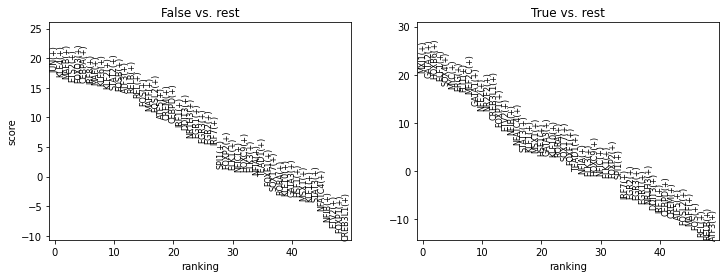

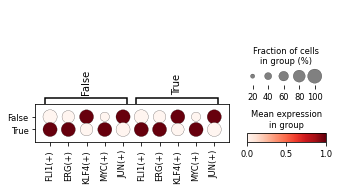

In [147]:
# DE

adata = adata[adata.obs['cell.labels'].isin(['Macrophage'])]
spot_var = 'mono_independent'
adata.obs['mono_independent'] = adata.obs['mono_independent'].astype('category')
sc.tl.rank_genes_groups(adata, spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name ="./Differential_regulon.csv"
DE.to_csv(DE_name)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(10, 'p_val')).reset_index(drop=True)
marker_df = marker_df.groupby('cluster').apply(lambda grp: grp.nlargest(5, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata
markers = markers
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_gastrula.pdf')) # title=i

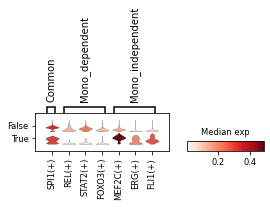

In [154]:
markers = {
    'Common' : ["SPI1(+)"],
    'Mono_dependent': ['REL(+)', 'STAT2(+)','FOXO3(+)'],
 'Mono_independent': [ 'MEF2C(+)','ERG(+)','FLI1(+)']}
sc.pl.stacked_violin(adata ,var_names= markers, groupby='mono_independent',  log=False, use_raw=None, num_categories=7, title=None, colorbar_title='Median exp', figsize=None, dendrogram=False, gene_symbols=None, var_group_positions=None, var_group_labels=None, standard_scale='var', var_group_rotation=None, layer=None, stripplot=False, jitter=False, size=1, scale='width', yticklabels=False, order=None, swap_axes=False, show=None, return_fig=False, row_palette=None, cmap='Reds', ax=None, vmin=None, vmax=None, vcenter=None, norm=None)

In [158]:
from itertools import chain
sig = [x for x in chain(*markers.values()) if x]

In [162]:
sig_gam.reindex(sig)

,p_val,positions
SPI1(+),0.946619,41.0
REL(+),0.376067,37.0
STAT2(+),NaN,NaN
FOXO3(+),0.602902,15.0
MEF2C(+),0.713510,30.0
ERG(+),0.857220,9.0
FLI1(+),0.898831,12.0


In [163]:
sig_gam = gam_out[gam_out.index.isin(sig)]
sig_gam = sig_gam.reindex(sig)

In [3]:
# Grab intersecting homolog TFs between human/mouse for each lineage

# Plot GAM outputs for significant GAMs across PSD

# Human

### Pre-mono

In [164]:
adata_hu = sc.read('./data/hu_diff_regulon_aucell.h5ad')
adata_hu_raw = sc.read('./data/hu_diff_regulon.h5ad')

In [11]:
lineage = 'Macrophage_pre'
species = 'hu'

In [12]:
gen_path = './gam_outs/' + lineage + '_' + species + '_'
dat_path = './data/' + lineage + '_' + species + '_'

adata_hu_tmp = sc.read(dat_path + 'lineage_trial_dffimap.h5ad')

In [13]:
list(adata_hu_tmp.obs['cell.labels'].unique())

['HSPC_1', 'Macrophage', 'Pre_Macrophage']

In [14]:
adata_hu_tmp = adata_hu_tmp[adata_hu_tmp.obs['stage'].isin(['CS10', 'CS11'])]

In [15]:
# import human_model
import pickle 
filename = gen_path + 'gam.pkl'
with open(filename, 'rb') as f:
    gam1 = pickle.load(f)
data = pd.read_csv(gen_path + 'regulon_dat.csv',index_col=0)
y = pd.read_csv(gen_path +'regulon_psd_time.csv',index_col=0)
gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
sig_gam = pd.read_csv(gen_path +'sig_gam.csv',index_col=0)
homologs = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
X = data
gam_grid = gam1

In [16]:
keep = ['SPI1']

In [17]:
sig_gam = gam_out[gam_out.index.isin(['GPX1(+)','SPI1(+)','RUNX3(+)','ID2(+)','KLF1(+)','IRF1(+)','SOX4(+)','MYC(+)','MXI1(+)'])]

In [18]:
sig_gam = gam_out[gam_out.index.isin(sig)]
sig_gam = sig_gam.reindex(sig)

NameError: name 'sig' is not defined

In [20]:
adata.var

""
Regulon
ATF3(+)
ATF5(+)
CEBPA(+)
CEBPD(+)
CREB3L1(+)
...
SOX4(+)
SPI1(+)
STAT2(+)


# Plot type 1

# Add color

In [21]:
gam1

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + intercept,
   tol=0.0001, verbose=False)

<Figure size 432x288 with 0 Axes>

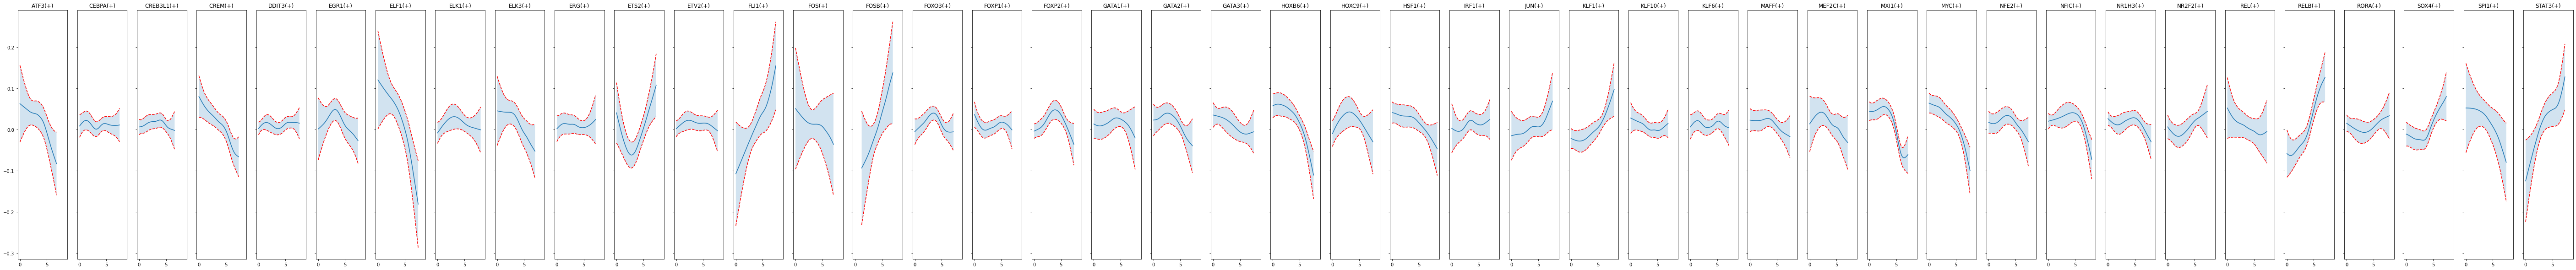

In [22]:
# Dependencies
regulons = gam_out.index.values
dependncies = X[gam_out.index.values]
gam1 = gam_grid
plt.figure();
#fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
fig, axs = plt.subplots(1,(dependncies.shape[1]),figsize=(100,10),sharex=True, sharey=True);

for z, ax in enumerate(axs):
    i = int(gam_out.iloc[z].positions)
    XX = gam1.generate_X_grid(term=i)
    dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.fill_between(XX[:, i], gam1.partial_dependence(term=i, X=XX, width=.95)[1][:,0],gam1.partial_dependence(term=i, X=XX, width=.95)[1][:,1], alpha=0.2)
    
    #if i == 0:
    #    ax.set_ylim(-30,30)
    #    ax.set_xlim(-30,30)
    ax.set_title(gam_out.iloc[z].name);
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_tight.pdf',dpi=500, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

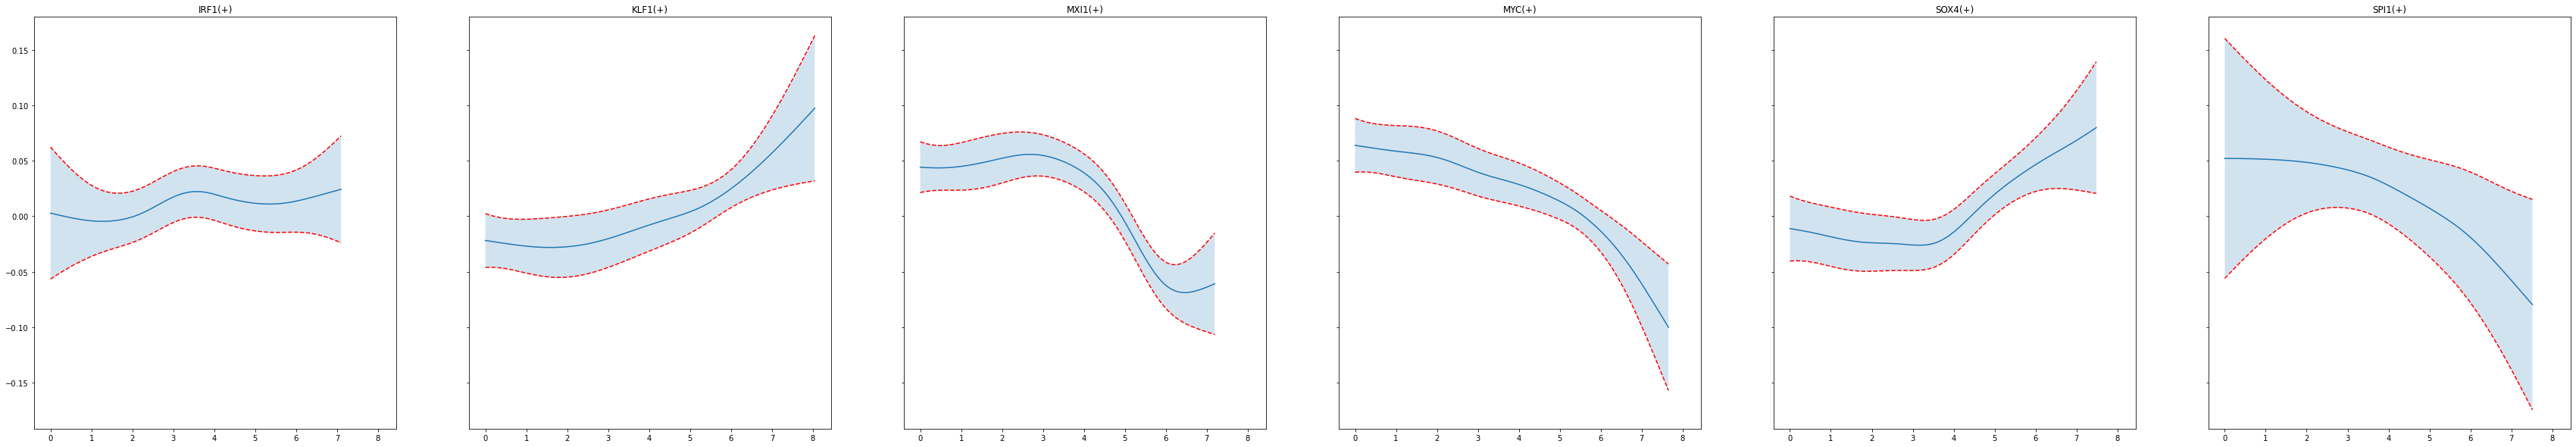

In [23]:
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();
#fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
fig, axs = plt.subplots(1,(dependncies.shape[1]),figsize=(60,10),sharex=True, sharey=True);

for z, ax in enumerate(axs):
    i = int(sig_gam.iloc[z].positions)
    XX = gam1.generate_X_grid(term=i)
    dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.fill_between(XX[:, i], gam1.partial_dependence(term=i, X=XX, width=.95)[1][:,0],gam1.partial_dependence(term=i, X=XX, width=.95)[1][:,1], alpha=0.2)
    
    #if i == 0:
    #    ax.set_ylim(-30,30)
    #    ax.set_xlim(-30,30)
    ax.set_title(sig_gam.iloc[z].name);
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_tight.pdf',dpi=500, bbox_inches="tight")

# Try to make boxplots

In [6]:
adata_post = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/mac_traj_pySCENIC_regulon/data/Macrophage_post_hu_lineage_trial_dffimap.h5ad')

In [123]:
adata_hu_raw = sc.read('./data/hu_diff_regulon_aucell.h5ad')

In [124]:
XX = gam1.generate_X_grid(term=i)
dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)

In [137]:
adata_hu_raw.obs['mono_independent'] = 'Unkown'
adata_hu_raw.obs.loc[adata_hu_raw.obs.index.isin(adata_pre.obs.index),'mono_independent'] = True
adata_hu_raw.obs.loc[adata_hu_raw.obs.index.isin(adata_post.obs.index),'mono_independent'] = False
adata = adata_hu_raw[~adata_hu_raw.obs['mono_independent'].isin(['Unkown'])]

adata.obs.groupby('mono_independent').count()

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(NR2F2(+)),Regulon(REL(+)),Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+))
mono_independent,,,,,,,,,,,,,,,,,,,,,
False,0,0,2657,0,0,2657,2657,2657,0,2657,...,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657
True,0,0,1715,0,0,1715,1715,1715,0,1715,...,1715,1715,1715,1715,1715,1715,1715,1715,1715,1715


In [138]:
adata = adata[adata.obs['mono_independent']==True]
adata.obs['dpt_order_indices'] = adata_pre.obs['dpt_order_indices']

Trying to set attribute `.obs` of view, copying.


In [139]:
adata.var

""
Regulon
ATF3(+)
ATF5(+)
CEBPA(+)
CEBPD(+)
CREB3L1(+)
...
SOX4(+)
SPI1(+)
STAT2(+)


In [146]:
adata.var[adata.var.index.isin(['GFI1(+)'])]

""
Regulon


In [145]:
boxer = adata[:,[sig_gam.iloc[z].name]]
boxer = adata[:,['CEBPA(+)']]
obs = adata.obs[:]
exp = pd.DataFrame(boxer.X)
exp.index = obs.index
exp.columns = ['exp']
obs = pd.concat([obs,exp],axis=1)
obs['bins']= obs.groupby('cell.labels')[['dpt_order_indices']].transform(lambda x: pd.cut(x, bins = 2).astype(str))

In [147]:
obs.groupby(['cell.labels','bins']).count()

barcode  sample  stage  sequencing.batch  \
cell.labels    bins                                                        
HSPC_1         (-1.714, 857.0]        0       0    770                 0   
               (25.315, 869.5]        0       0      0                 0   
               (26.558, 749.0]        0       0      0                 0   
               (749.0, 1470.0]        0       0      0                 0   
               (857.0, 1714.0]        0       0    755                 0   
               (869.5, 1712.0]        0       0      0                 0   
Pre_Macrophage (-1.714, 857.0]        0       0      0                 0   
               (25.315, 869.5]        0       0      0                 0   
               (26.558, 749.0]        0       0     11                 0   
               (749.0, 1470.0]        0       0     13                 0   
               (857.0, 1714.0]        0       0      0                 0   
               (869.5, 1712.0]        0       0      0                 0   
Macrophage     (-1.714, 857.0]        0       0      0                 0   
               (25.315, 869.5]        0       0     77                 0   
               (26.558, 749.0]        0       0      0                 0   
               (749.0, 1470.0]        0       0      0                 0   
               (857.0, 1714.0]        0       0      0                 0   
               (869.5, 1712.0]        0       0     89                 0   

                                celltype  species  species_donor  n_counts  \
cell.labels    bins                                                          
HSPC_1         (-1.714, 857.0]         0      770            770       770   
               (25.315, 869.5]         0        0              0         0   
               (26.558, 749.0]         0        0              0         0   
               (749.0, 1470.0]         0        0              0         0   
               (857.0, 1714.0]         0      755            755       755   
               (869.5, 1712.0]         0        0              0         0   
Pre_Macrophage (-1.714, 857.0]         0        0              0         0   
               (25.315, 869.5]         0        0              0         0   
               (26.558, 749.0]         0       11             11        11   
               (749.0, 1470.0]         0       13             13        13   
               (857.0, 1714.0]         0        0              0         0   
               (869.5, 1712.0]         0        0              0         0   
Macrophage     (-1.714, 857.0]         0        0              0         0   
               (25.315, 869.5]         0       77             77        77   
               (26.558, 749.0]         0        0              0         0   
               (749.0, 1470.0]         0        0              0         0   
               (857.0, 1714.0]         0        0              0         0   
               (869.5, 1712.0]         0       89             89        89   

                                restricted_celltype  n_genes  ...  \
cell.labels    bins                                           ...   
HSPC_1         (-1.714, 857.0]                    0      770  ...   
               (25.315, 869.5]                    0        0  ...   
               (26.558, 749.0]                    0        0  ...   
               (749.0, 1470.0]                    0        0  ...   
               (857.0, 1714.0]                    0      755  ...   
               (869.5, 1712.0]                    0        0  ...   
Pre_Macrophage (-1.714, 857.0]                    0        0  ...   
               (25.315, 869.5]                    0        0  ...   
               (26.558, 749.0]                    0       11  ...   
               (749.0, 1470.0]                    0       13  ...   
               (857.0, 1714.0]                    0        0  ...   
               (869.5, 1712.0]                    0  

In [148]:
data

,ATF3(+),CEBPA(+),CREB3L1(+),CREM(+),DDIT3(+),EGR1(+),ELF1(+),ELK1(+),ELK3(+),ERG(+),...,NFE2(+),NFIC(+),NR1H3(+),NR2F2(+),REL(+),RELB(+),RORA(+),SOX4(+),SPI1(+),STAT3(+)
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1,5.451402,2.826847,4.187417,5.265779,0.000000,6.692912,6.163439,0.000000,5.352208,6.349840,...,4.953000,0.000000,0.000000,1.684729,4.737721,3.910279,5.953495,6.458766,6.190946,4.970988
Cell_dat_Yolksac_Cell_dat_Yolksac_ACTGCTCCATCTATGG_2,4.246028,4.710172,4.127180,3.782353,5.503115,4.839004,6.156324,0.000000,5.620021,6.148879,...,5.317965,0.000000,0.000000,5.626837,3.685144,3.437332,0.000000,7.115767,6.154593,5.246758
Cell_dat_Yolksac_Cell_dat_Yolksac_TGAAAGAGTAGCGTGA_2,4.131927,4.714123,3.884620,3.885835,0.000000,4.906953,5.452114,0.000000,5.869967,6.126961,...,4.483119,0.000000,0.000000,5.809815,3.714372,3.352217,0.000000,6.752437,5.928076,4.610768
Cell_dat_Yolksac_Cell_dat_Yolksac_CACACAAGTCCGTTAA_2,4.461795,4.970069,5.455275,4.513094,0.000000,4.862978,5.477985,0.000000,5.836245,6.233470,...,4.949023,0.000000,0.000000,5.884493,4.621431,4.735181,4.834836,6.435576,5.851860,4.635635
Cell_dat_Yolksac_Cell_dat_Yolksac_TTGCCGTGTCTTGTCC_2,5.131505,5.313997,3.990540,5.423898,0.000000,6.352845,5.425368,0.000000,5.626049,6.264789,...,4.240100,0.000000,0.000000,0.000000,5.357646,4.748862,6.792768,5.881832,6.366041,4.513001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F79_Yolksac_45N_FCAImmP8096689_GTTCATTAGGACGAAA,6.419257,5.379703,4.166312,7.005757,4.900694,6.117311,4.962676,0.000000,5.357155,3.163382,...,0.000000,0.000000,6.992513,0.000000,7.025361,6.420187,0.000000,0.000000,6.296575,4.661263
F79_Yolksac_45N_FCAImmP8096689_GTCCTCACATGCTGGC,6.481438,5.981141,3.811073,5.965863,4.434819,6.527484,4.911584,0.000000,6.088639,2.709843,...,3.767225,0.000000,3.945324,0.000000,6.407901,5.975068,0.000000,1.547435,6.612568,5.203066
F61_Yolksac_CD45+_FCAImmP7862088_GCTGCAGGTAATTGGA,5.157997,3.534117,4.511270,5.284383,2.473018,5.850769,6.459631,0.000000,4.321164,6.215258,...,6.030432,0.000000,0.000000,2.910983,4.963272,5.149016,5.878073,6.520202,5.334370,6.152774
F61_Yolksac_CD45+_FCAImmP7862088_GATCAGTCACCCAGTG,5.326714,6.072954,3.485490,3.517599,5.219305,4.083291,4.835942,0.000000,5.471341,3.452115,...,2.225587,7.848314,2.715465,0.000000,4.914056,5.496397,0.000000,0.000000,6.349513,5.514500


In [149]:
# colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']
# sns.boxplot(x=DMC, y=day, palette=colors)

Text(0.5, 1.0, 'feature = f1')

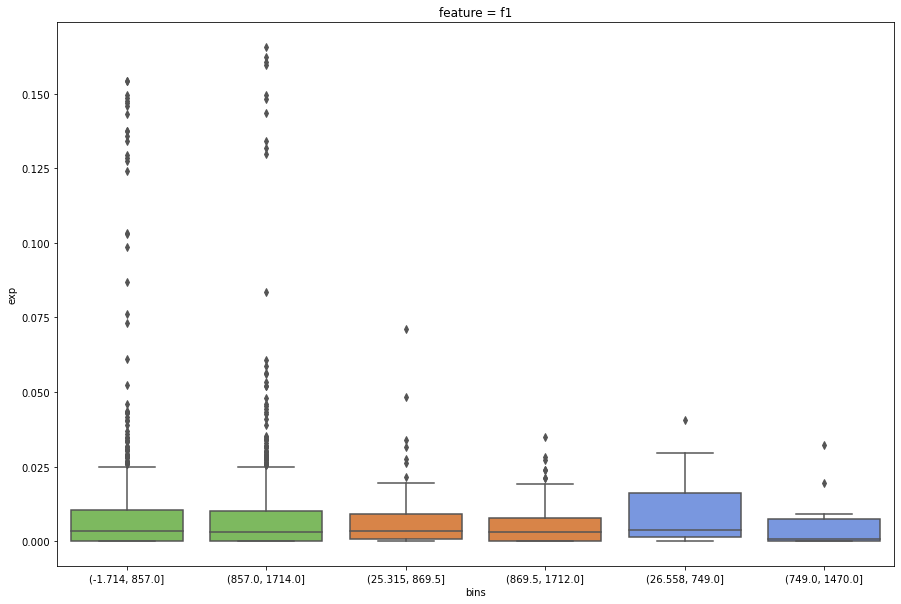

In [150]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
colors = ['#78C850','#78C850', '#F08030','#F08030', '#6890F0','#6890F0']
sns.boxplot(data=obs, x='bins', y='exp', ax=ax1,palette=colors)
ax1.set_title('feature = f1')

# Just HSPC1

In [117]:
adata.obs.groupby('mono_independent').count()

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(NR2F2(+)),Regulon(REL(+)),Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+))
mono_independent,,,,,,,,,,,,,,,,,,,,,
False,0,0,2657,0,0,2657,2657,2657,0,2657,...,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657
True,0,0,1715,0,0,1715,1715,1715,0,1715,...,1715,1715,1715,1715,1715,1715,1715,1715,1715,1715


In [64]:
obs

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+)),mono_independent,0
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,18531.0,NaN,3605,...,0.004981,0.000000,0.012283,0.089558,0.050418,0.007292,0.029190,0.0,True,0.068456
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGATGGTTGGACCC_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,32454.0,NaN,5098,...,0.006380,0.000000,0.000000,0.093214,0.042705,0.006504,0.026026,0.0,True,0.056878
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGTAGAGTGGTCCC_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,25971.0,NaN,3844,...,0.011854,0.000000,0.000000,0.149839,0.071686,0.007831,0.022585,0.0,True,0.071485
Cell_dat_Yolksac_Cell_dat_Yolksac_AACACGTGTTGATTCG_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,26405.0,NaN,4324,...,0.004333,0.045041,0.000000,0.172469,0.037798,0.035335,0.023484,0.0,True,0.056135
Cell_dat_Yolksac_Cell_dat_Yolksac_AACGTTGAGGGTGTTG_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,20701.0,NaN,3627,...,0.008978,0.000000,0.000000,0.170002,0.055686,0.008208,0.018572,0.0,True,0.065890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F79_Yolksac_Hep_FCAImmP8096691_GTTCTCGAGTATTGGA,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,9263.0,NaN,2849,...,0.055139,0.000000,0.000000,0.000950,0.039560,0.020467,0.028264,0.0,False,0.062441
F79_Yolksac_Hep_FCAImmP8096691_TACGGATTCTTGTCAT,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,20186.0,NaN,4240,...,0.026838,0.000000,0.055272,0.038440,0.035724,0.032050,0.033859,0.0,False,0.059665
F79_Yolksac_Hep_FCAImmP8096691_TCGCGAGGTGTCCTCT,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,15311.0,NaN,3390,...,0.040097,0.028625,0.142277,0.116526,0.063486,0.024625,0.031371,0.0,False,0.035708
F79_Yolksac_Hep_FCAImmP8096691_TGCGCAGCAGTCTTCC,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,8783.0,NaN,2317,...,0.016057,0.004405,0.000000,0.041208,0.026120,0.046584,0.040952,0.0,False,0.074734


In [ ]:
obs.groupby()

In [62]:
obs

,barcode,sample,stage,sequencing.batch,celltype,species,species_donor,n_counts,restricted_celltype,n_genes,...,Regulon(RELB(+)),Regulon(RORA(+)),Regulon(SOX17(+)),Regulon(SOX4(+)),Regulon(SPI1(+)),Regulon(STAT2(+)),Regulon(STAT3(+)),Regulon(TEAD1(+)),mono_independent,0
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,18531.0,NaN,3605,...,0.004981,0.000000,0.012283,0.089558,0.050418,0.007292,0.029190,0.0,True,0.068456
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGATGGTTGGACCC_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,32454.0,NaN,5098,...,0.006380,0.000000,0.000000,0.093214,0.042705,0.006504,0.026026,0.0,True,0.056878
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGTAGAGTGGTCCC_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,25971.0,NaN,3844,...,0.011854,0.000000,0.000000,0.149839,0.071686,0.007831,0.022585,0.0,True,0.071485
Cell_dat_Yolksac_Cell_dat_Yolksac_AACACGTGTTGATTCG_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,26405.0,NaN,4324,...,0.004333,0.045041,0.000000,0.172469,0.037798,0.035335,0.023484,0.0,True,0.056135
Cell_dat_Yolksac_Cell_dat_Yolksac_AACGTTGAGGGTGTTG_1,NaN,NaN,CS10,NaN,NaN,Human,Human_Wang_CS10,20701.0,NaN,3627,...,0.008978,0.000000,0.000000,0.170002,0.055686,0.008208,0.018572,0.0,True,0.065890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F79_Yolksac_Hep_FCAImmP8096691_GTTCTCGAGTATTGGA,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,9263.0,NaN,2849,...,0.055139,0.000000,0.000000,0.000950,0.039560,0.020467,0.028264,0.0,False,0.062441
F79_Yolksac_Hep_FCAImmP8096691_TACGGATTCTTGTCAT,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,20186.0,NaN,4240,...,0.026838,0.000000,0.055272,0.038440,0.035724,0.032050,0.033859,0.0,False,0.059665
F79_Yolksac_Hep_FCAImmP8096691_TCGCGAGGTGTCCTCT,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,15311.0,NaN,3390,...,0.040097,0.028625,0.142277,0.116526,0.063486,0.024625,0.031371,0.0,False,0.035708
F79_Yolksac_Hep_FCAImmP8096691_TGCGCAGCAGTCTTCC,NaN,NaN,CS18,NaN,NaN,Human,Human_F79,8783.0,NaN,2317,...,0.016057,0.004405,0.000000,0.041208,0.026120,0.046584,0.040952,0.0,False,0.074734


In [29]:
dependence

array([ 5.20189369e-02,  5.20039617e-02,  5.19861228e-02,  5.19642936e-02,
        5.19373474e-02,  5.19041577e-02,  5.18635983e-02,  5.18147236e-02,
        5.17570174e-02,  5.16900263e-02,  5.16132968e-02,  5.15263755e-02,
        5.14288086e-02,  5.13201250e-02,  5.11998281e-02,  5.10674191e-02,
        5.09223995e-02,  5.07642705e-02,  5.05925126e-02,  5.04061884e-02,
        5.02039736e-02,  4.99845289e-02,  4.97465154e-02,  4.94885940e-02,
        4.92094589e-02,  4.89081410e-02,  4.85838669e-02,  4.82358655e-02,
        4.78633656e-02,  4.74655962e-02,  4.70419009e-02,  4.65922789e-02,
        4.61169616e-02,  4.56161804e-02,  4.50901672e-02,  4.45391533e-02,
        4.39627026e-02,  4.33581386e-02,  4.27223155e-02,  4.20520877e-02,
        4.13443094e-02,  4.05958306e-02,  3.98029005e-02,  3.89605530e-02,
        3.80636755e-02,  3.71071554e-02,  3.60858800e-02,  3.49948671e-02,
        3.38338718e-02,  3.26086151e-02,  3.13251986e-02,  2.99897238e-02,
        2.86082921e-02,  

# Plot type 2

In [24]:
sig_gam

,p_val,positions
IRF1(+),4.755471e-01,24
KLF1(+),7.079309e-01,26
MXI1(+),3.486958e-10,31
MYC(+),5.379425e-04,32
SOX4(+),2.171832e-02,40
SPI1(+),9.580804e-01,41


In [75]:
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].mean()
pseudotime_label_ordering

,dpt_pseudotime
cell.labels,
HSPC_1,0.061984
Pre_Macrophage,0.233555
Macrophage,0.836449


<ipython-input-76-3ce14408f4d5>:20: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


IndexError: single positional indexer is out-of-bounds

<Figure size 432x288 with 0 Axes>

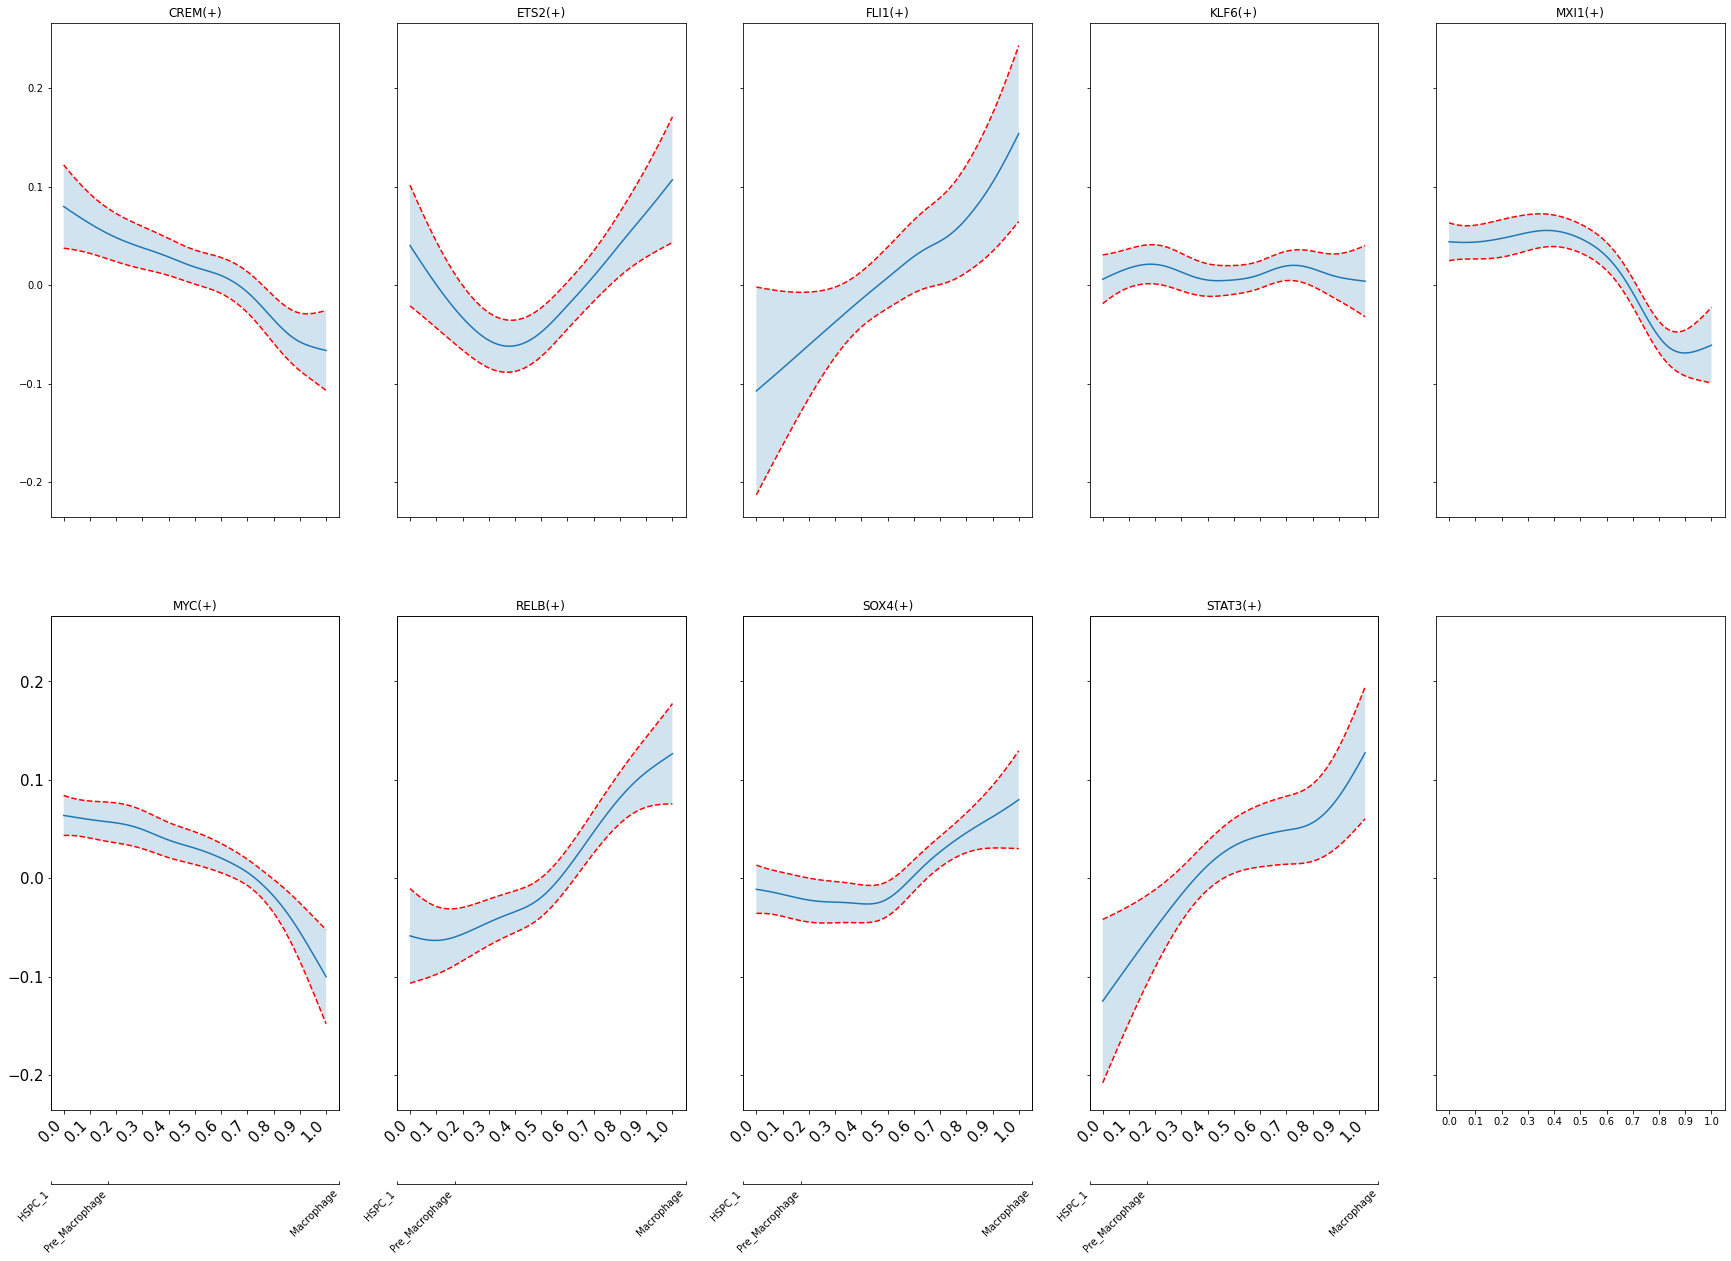

In [76]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
sig_gam = gam_out[gam_out['p_val']<0.05]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))
# # Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
# pseudotime_label_ordering['dpt_pseudotime'] = [0.13958510756492615,
#  0.3872923612594604,
#  0.5650753259658813,
#  0.7564111590385437,
#  0.8310452103614807,
#  0.9205611944198608]
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    # redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
pseudotime_label_ordering   

# # Round to 2dp
pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(1,grid_shape,figsize=(30,10*grid_shape),sharex=True, sharey=True);

    
#for z, ax in enumerate(axs):
#    i = int(sig_gam.iloc[z].positions)
    
#fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
counter_x = 0
for i, ax in enumerate(axs):
    for z in range(0,len(ax)): 
        
        counter = int(sig_gam.iloc[counter_x].positions)
        
        XX = gam1.generate_X_grid(term=counter)
        dependence = gam1.partial_dependence(counter, X=XX, width=None, quantiles=None, meshgrid=False)
        ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
        ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.90)[1], c='r', ls='--')
        ax[z].set_title(sig_gam.iloc[counter_x].name)
        ax[z].fill_between(NormalizeData(XX[:, counter]),gam1.partial_dependence(term=counter, X=XX, width=.90)[1][:,0],gam1.partial_dependence(term=counter, X=XX, width=.90)[1][:,1], alpha=0.2)
        ranger = list(range(0,11))
        ranger[:] = [x / 10 for x in ranger]
        #ax[z].set_xticks(ranger, minor=False)
        
        p , n = list(enumerate(axs))[-1]
        if i == p : 
            ax[z].set_xticks(ranger, minor=False)
            ax[z].tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax[z].twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_square_panels.pdf',dpi=500, bbox_inches="tight")

In [77]:
cell_label_pal = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_cell_labels_pal_150921.csv")

In [78]:
## Vars
adata_var = "cell.labels"
var = 'cell.labels'
col_pal = cell_label_pal 

In [79]:
pal = pd.read_csv(col_pal)
pal = pal[pal['categories'].isin(list(pseudotime_label_ordering.index))]
pal.index = pal['categories']
pseudotime_label_ordering_pal = pseudotime_label_ordering[:]
pseudotime_label_ordering_pal['col'] = pal['color']
pseudotime_label_ordering_pal

<ipython-input-79-5fbba0fb071c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudotime_label_ordering_pal['col'] = pal['color']


,dpt_pseudotime,col
cell.labels,,
HSPC_1,0.00,#afbfcc
Pre_Macrophage,0.25,#66b1d2
Macrophage,1.00,#4c7bab


# Plot type 3 top 3 most significant

In [80]:
NormalizeData(XX[:, i])

<ipython-input-76-3ce14408f4d5>:10: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [81]:
gam1.generate_X_grid

<bound method GAM.generate_X_grid of LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + intercept,
   tol=0.0001, verbose=False)>

In [90]:
sig_gam

,p_val,positions
IRF1(+),4.755471e-01,24
KLF1(+),7.079309e-01,26
MXI1(+),3.486958e-10,31
MYC(+),5.379425e-04,32
SOX4(+),2.171832e-02,40
SPI1(+),9.580804e-01,41


In [89]:
regulons

array(['IRF1(+)', 'KLF1(+)', 'MXI1(+)', 'MYC(+)', 'SOX4(+)', 'SPI1(+)'],
      dtype=object)

<ipython-input-92-49ff0ba032bb>:35: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


TypeError: object of type 'AxesSubplot' has no len()

<Figure size 432x288 with 0 Axes>

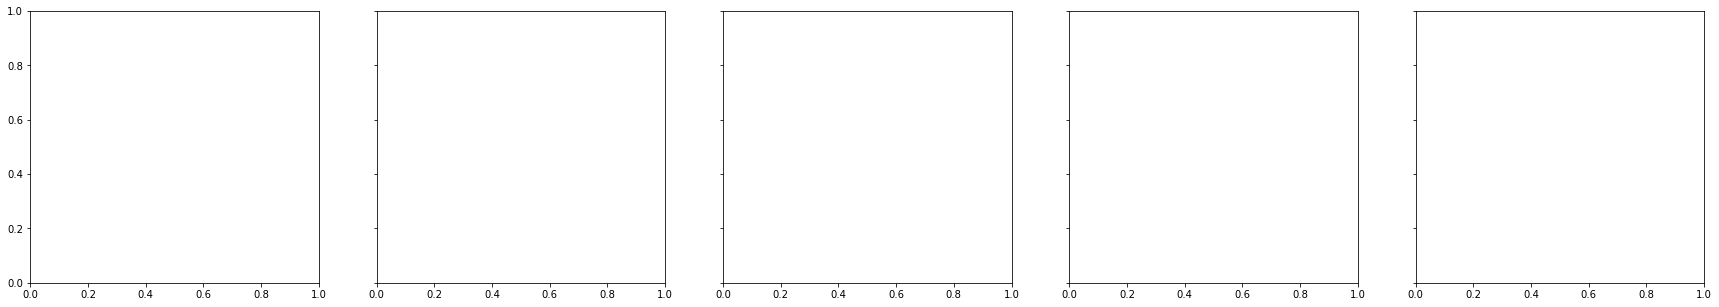

In [92]:
# gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
# gam_out['positions'] = list(range(0,len(gam_out)))
gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
# sig_gam = pd.read_csv(gen_path +'sig_gam.csv',index_col=0)
sig_gam = gam_out[gam_out.index.isin(['GPX1(+)','SPI1(+)','RUNX3(+)','ID2(+)','KLF1(+)','IRF1(+)','SOX4(+)','MYC(+)','MXI1(+)']) ]#gam_out.nsmallest(5, 'p_val', keep='first')
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']

# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,5*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.90)[1], c='r', ls='--')
            ax[z].fill_between(NormalizeData(XX[:, counter]),gam1.partial_dependence(term=counter, X=XX, width=.90)[1][:,0],gam1.partial_dependence(term=counter, X=XX, width=.90)[1][:,1], alpha=0.2, color='orange')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(5,4*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.90)[1], c='r', ls='--')
        ax.fill_between(NormalizeData(XX[:, i]),gam1.partial_dependence(term=i, X=XX, width=.90)[1][:,0],gam1.partial_dependence(term=i, X=XX, width=.90)[1][:,1], alpha=0.2,color='red')
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'

        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name,fontweight="bold",fontsize = 20);
        
fig.tight_layout()
        
# Make color bar
rv_dpt_pseudotime = list(map(lambda dpt_pseudotime: dpt_pseudotime + 0.5, dpt_pseudotime))
rv_dpt_pseudotime.reverse()
ax_bar = pd.DataFrame(rv_dpt_pseudotime).T.plot.barh(stacked=True,legend=False,figsize=(10,1))
ax_bar.get_xaxis().set_ticks([])
ax_bar.get_yaxis().set_ticks([])
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['left'].set_visible(False)     
        
fig.savefig('./figures/' + lineage +'_hu_top5_sig_regulons.pdf',dpi=500, bbox_inches="tight")
plt.savefig('./figures/' + lineage +'_hu_top5_sig_regulons_color_legend.pdf',dpi=500, bbox_inches="tight")

# Plot type 4 :: Top 3 intersect human and mouse

In [59]:
lineage = 'Macrophage_post'
species = 'hu'
gen_path = './gam_outs/' + lineage + '_' + species + '_'
dat_path = './data/' + lineage + '_' + species + '_'
ms_gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
ms_sig_gam = ms_gam_out.nsmallest(10, 'p_val', keep='first')

In [60]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
hu_sig_gam = gam_out[gam_out['p_val']<0.05]


In [61]:
# Check intersect
hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]
hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)]

,p_val,positions
CREB3L1(+),3.023409e-02,2
CREM(+),9.160450e-03,3
ELF1(+),1.545886e-03,6
FLI1(+),7.847377e-03,12
HOXB6(+),1.082564e-02,21
JUN(+),5.524208e-03,25
MXI1(+),4.715202e-07,31
NR2F2(+),3.365883e-02,36
RORA(+),6.921652e-03,39
STAT3(+),1.459263e-02,42


In [21]:
hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)].to_csv('./data/'+lineage + '_hu_ms_intersect.csv')
ms_non = ms_sig_gam[~ms_sig_gam.index.isin(hu_sig_gam.index)]
ms_non['species_unique'] = 'ms'
hu_non = hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]
hu_non['species_unique'] = 'hu'
pd.concat([ms_non,hu_non]).to_csv('./data/'+lineage + '_hu_ms_non_intersect.csv')
pd.concat([ms_non,hu_non])

<ipython-input-21-4d143454a721>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ms_non['species_unique'] = 'ms'
<ipython-input-21-4d143454a721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hu_non['species_unique'] = 'hu'


,p_val,positions,species_unique
ELF1(+),0.001546,6,ms
RORA(+),0.006922,39,ms
FLI1(+),0.007847,12,ms
CREM(+),0.009160,3,ms
STAT3(+),0.014593,42,ms
CREB3L1(+),0.030234,2,ms
NR2F2(+),0.033659,36,ms
ATF3(+),0.016585,0,hu
ELK3(+),0.018394,8,hu
FOXP2(+),0.001238,17,hu


In [22]:
hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]

,p_val,positions
ATF3(+),0.016585,0
ELK3(+),0.018394,8
FOXP2(+),0.001238,17
MEF2C(+),0.002296,30
REL(+),0.006222,37
SPI1(+),0.047653,41


In [23]:
ms_sig_gam[~ms_sig_gam.index.isin(hu_sig_gam.index)]

,p_val,positions
ELF1(+),0.001546,6
RORA(+),0.006922,39
FLI1(+),0.007847,12
CREM(+),0.009160,3
STAT3(+),0.014593,42
CREB3L1(+),0.030234,2
NR2F2(+),0.033659,36


In [24]:
sig_gam = hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)]
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

In [25]:
regulons

array(['HOXB6(+)', 'JUN(+)', 'MXI1(+)'], dtype=object)

<ipython-input-26-b9cfa33bb6bf>:27: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


<Figure size 432x288 with 0 Axes>

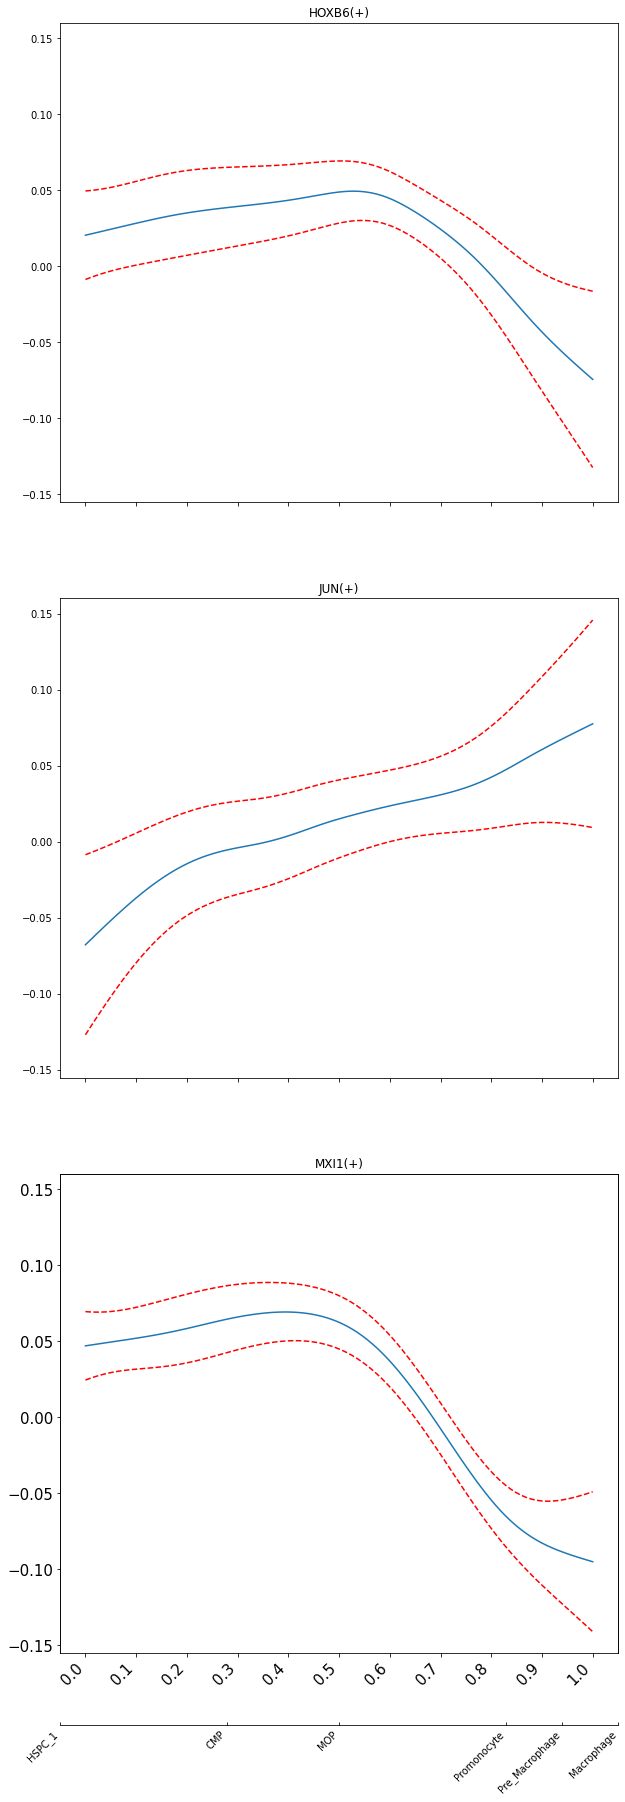

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']

# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(10,10*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name);
        
plt.savefig('./figures/' + lineage +'_hu_top5_intersecting_species_sig_regulons.pdf',dpi=500, bbox_inches="tight")

In [27]:
# Post

In [28]:
hu_lineages = {
# 'Erythroid':['HSPC_1','HSPC_2','MEMP','Early_Erythroid','Erythroid',],
# 'Macrophage':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Pre_Macrophage','Macrophage',],
# 'MK':['HSPC_1','HSPC_2','MEMP','MK']
'Macrophage_pre':['HSPC_1','HSPC_2','CMP','MOP','Promonocyte','Pre_Macrophage','Macrophage',],
'Macrophage_post':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Pre_Macrophage','Macrophage',],
}

In [29]:
# Grab intersecting homolog TFs between human/mouse for each lineage

# Plot GAM outputs for significant GAMs across PSD

# Human

### Post-mono

In [95]:
adata_hu = sc.read('./data/hu_diff_regulon_aucell.h5ad')
adata_hu_raw = sc.read('./data/hu_diff_regulon.h5ad')

In [96]:
lineage = 'Macrophage_post'
species = 'hu'

In [97]:
gen_path = './gam_outs/' + lineage + '_' + species + '_'
dat_path = './data/' + lineage + '_' + species + '_'
adata_hu_tmp = sc.read(dat_path + 'lineage_trial_dffimap.h5ad')

In [98]:
list(adata_hu_tmp.obs['cell.labels'].unique())

['Monocyte',
 'HSPC_1',
 'Promonocyte',
 'Monocyte_Macrophage',
 'Macrophage',
 'CMP',
 'MOP']

In [99]:
#adata_hu_tmp = adata_hu_tmp[adata_hu_tmp.obs['stage'].isin(['CS10', 'CS11'])]

In [110]:
# import human_model
import pickle 
filename = gen_path + 'gam.pkl'
with open(filename, 'rb') as f:
    gam1 = pickle.load(f)
data = pd.read_csv(gen_path + 'regulon_dat.csv',index_col=0)
y = pd.read_csv(gen_path +'regulon_psd_time.csv',index_col=0)
gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
sig_gam = pd.read_csv(gen_path +'sig_gam.csv',index_col=0)
homologs = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
X = data
gam_grid = gam1

In [112]:
sig_gam = gam_out[gam_out.index.isin(['GPX1(+)','SPI1(+)','RUNX3(+)','ID2(+)','KLF1(+)','IRF1(+)','SOX4(+)','MYC(+)','MXI1(+)'])]

In [113]:
sig_gam

,p_val,positions
IRF1(+),0.472200,24
KLF1(+),0.311117,26
MXI1(+),0.960484,31
MYC(+),0.444837,32
SOX4(+),0.947145,40
SPI1(+),0.946619,41


In [111]:
gam_out

,p_val,positions
ATF3(+),0.825709,0
CEBPA(+),0.963025,1
CREB3L1(+),0.745487,2
CREM(+),0.858976,3
DDIT3(+),0.679052,4
EGR1(+),0.853203,5
ELF1(+),0.306000,6
ELK1(+),0.273880,7
ELK3(+),0.122026,8
ERG(+),0.857220,9


# Plot type 1

<Figure size 432x288 with 0 Axes>

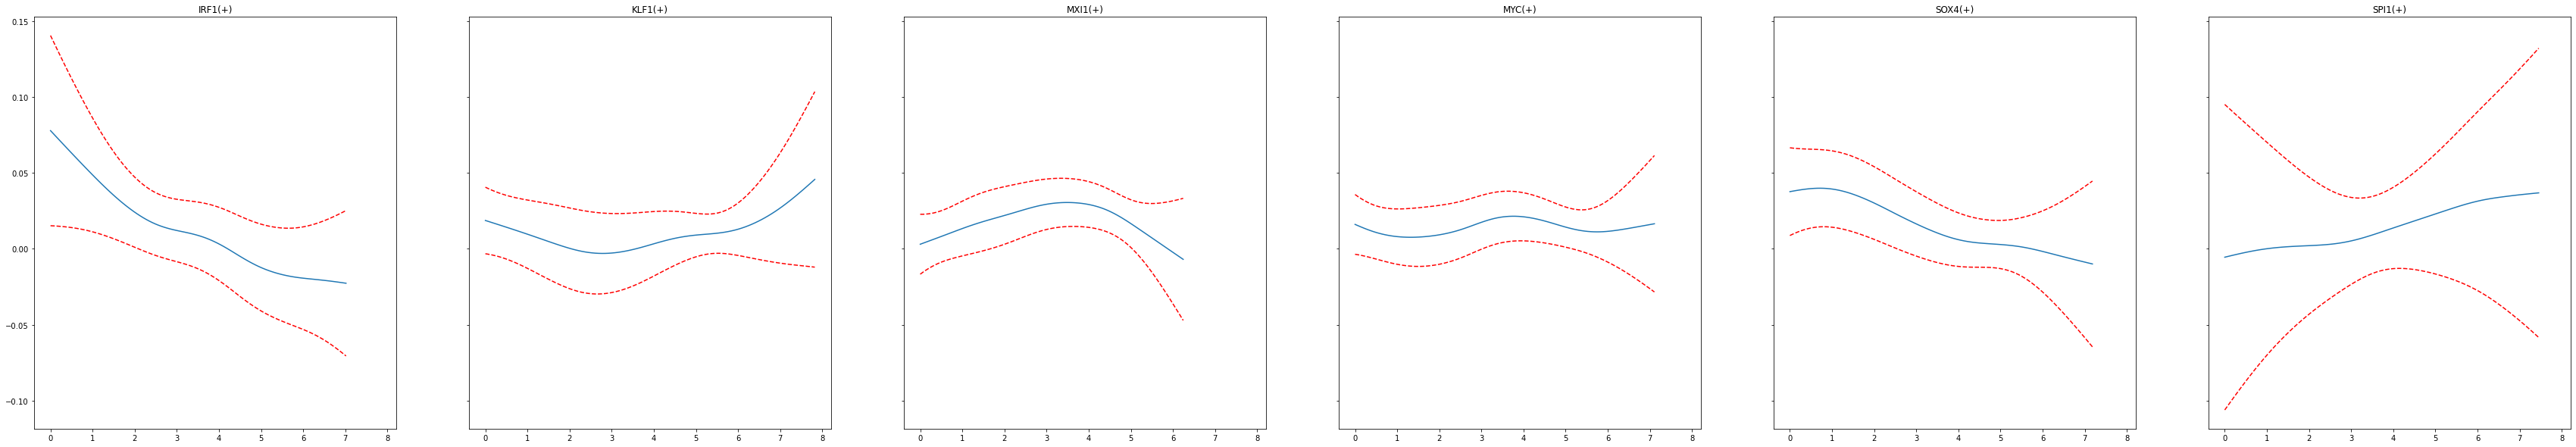

In [114]:
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
sig_gam = gam_out[gam_out.index.isin(['GPX1(+)','SPI1(+)','RUNX3(+)','ID2(+)','KLF1(+)','IRF1(+)','SOX4(+)','MYC(+)','MXI1(+)'])]
plt.figure();
#fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
fig, axs = plt.subplots(1,(dependncies.shape[1]),figsize=(60,10),sharex=True, sharey=True);

for z, ax in enumerate(axs):
    i = int(sig_gam.iloc[z].positions)
    XX = gam1.generate_X_grid(term=i)
    dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX, width=.90)[1], c='r', ls='--')
    
    #if i == 0:
    #    ax.set_ylim(-30,30)
    #    ax.set_xlim(-30,30)
    ax.set_title(sig_gam.iloc[z].name);
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_tight.pdf',dpi=500, bbox_inches="tight")

# Plot type 2

In [104]:
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))
# # Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
pseudotime_label_ordering['dpt_pseudotime'] = [0.0,
 0.3700000047683716,
 0.4500000238418579,
 0.600000166893005,
 0.7599999785423279,
 0.8700000047683716,
 1.0]


In [105]:
pseudotime_label_ordering

,dpt_pseudotime
cell.labels,
HSPC_1,0.00
CMP,0.37
MOP,0.45
Promonocyte,0.60
Monocyte,0.76
Monocyte_Macrophage,0.87
Macrophage,1.00


In [106]:
ax.set_xticks([])

[]

<ipython-input-107-1aae100b69aa>:29: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


<Figure size 432x288 with 0 Axes>

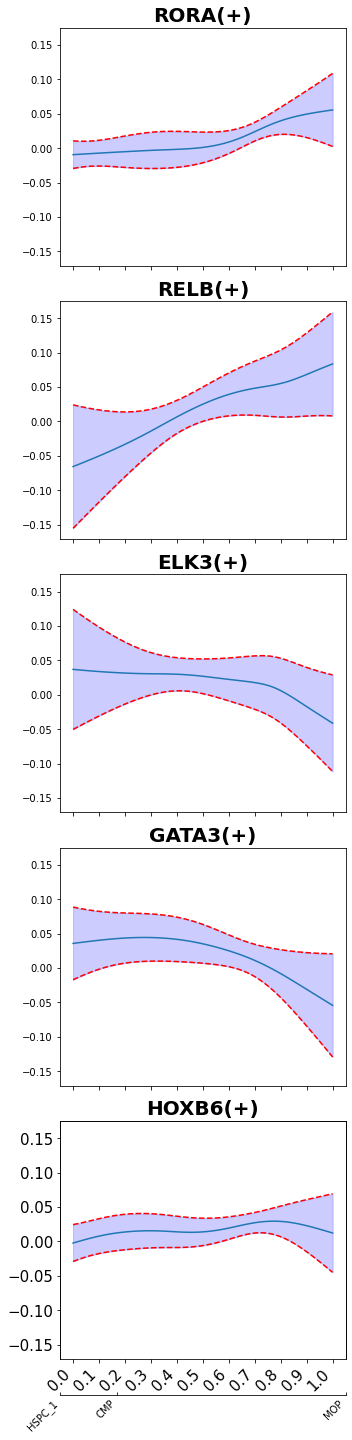

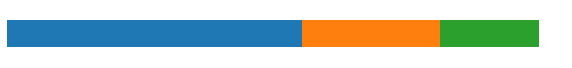

In [107]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
sig_gam = gam_out.nsmallest(5, 'p_val', keep='first')
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
    
pseudotime_label_ordering['dpt_pseudotime'] = [0.0,
 0.3700000047683716,
 0.4500000238418579,
 0.600000166893005,
 0.7599999785423279,
 0.8700000047683716,
 1.0]    


# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,5*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.90)[1], c='r', ls='--')
            ax[z].fill_between(NormalizeData(XX[:, counter]),gam1.partial_dependence(term=counter, X=XX, width=.90)[1][:,0],gam1.partial_dependence(term=counter, X=XX, width=.90)[1][:,1], alpha=0.2, color='orange')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(5,4*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.90)[1], c='r', ls='--')
        ax.fill_between(NormalizeData(XX[:, i]),gam1.partial_dependence(term=i, X=XX, width=.90)[1][:,0],gam1.partial_dependence(term=i, X=XX, width=.90)[1][:,1], alpha=0.2,color='blue')
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'

        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name,fontweight="bold",fontsize = 20);
        
fig.tight_layout()
        
# Make color bar
rv_dpt_pseudotime = list(map(lambda dpt_pseudotime: dpt_pseudotime + 0.5, dpt_pseudotime))
rv_dpt_pseudotime.reverse()
ax_bar = pd.DataFrame(rv_dpt_pseudotime).T.plot.barh(stacked=True,legend=False,figsize=(10,1))
ax_bar.get_xaxis().set_ticks([])
ax_bar.get_yaxis().set_ticks([])
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['left'].set_visible(False)     
        
fig.savefig('./figures/' + lineage +'_hu_top5_sig_regulons.pdf',dpi=500, bbox_inches="tight")
plt.savefig('./figures/' + lineage +'_hu_top5_sig_regulons_color_legend.pdf',dpi=500, bbox_inches="tight")

<ipython-input-512-0cc41ecf0db2>:21: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


TypeError: 'AxesSubplot' object is not iterable

<Figure size 432x288 with 0 Axes>

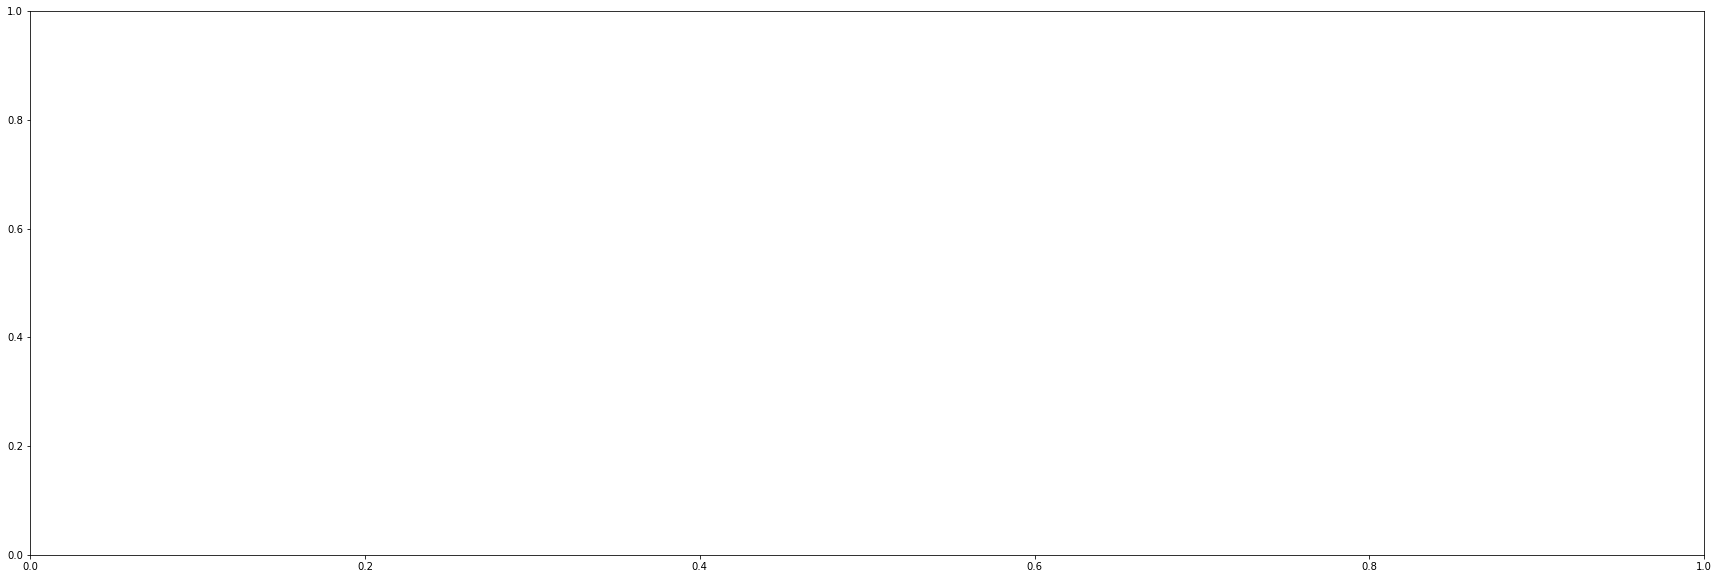

In [512]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
sig_gam = gam_out[gam_out['p_val']<0.05]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))
# # Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
pseudotime_label_ordering['dpt_pseudotime'] = [0.0,
 0.3700000047683716,
 0.4500000238418579,
 0.600000166893005,
 0.7599999785423279,
 0.8700000047683716,
 1.0]
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    # redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
pseudotime_label_ordering   

# # Round to 2dp
pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(1,grid_shape,figsize=(30,10*grid_shape),sharex=True, sharey=True);

    
#for z, ax in enumerate(axs):
#    i = int(sig_gam.iloc[z].positions)
    
#fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
counter_x = 0
for i, ax in enumerate(axs):
    for z in range(0,len(ax)): 
        
        counter = int(sig_gam.iloc[counter_x].positions)
        
        XX = gam1.generate_X_grid(term=counter)
        dependence = gam1.partial_dependence(counter, X=XX, width=None, quantiles=None, meshgrid=False)
        ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
        ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
        ax[z].set_title(sig_gam.iloc[counter_x].name)
        ranger = list(range(0,11))
        ranger[:] = [x / 10 for x in ranger]
        #ax[z].set_xticks(ranger, minor=False)
        
        p , n = list(enumerate(axs))[-1]
        if i == p : 
            ax[z].set_xticks(ranger, minor=False)
            ax[z].tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax[z].twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_square_panels.pdf',dpi=500, bbox_inches="tight")

# Plot type 3 top 3 most significant

In [413]:
sig_gam = gam_out.nsmallest(5, 'p_val', keep='first')

In [415]:
sig_gam

,p_val,positions
JUN(+),0.001189,25
NR1H3(+),0.005687,35
DDIT3(+),0.006608,4
ATF3(+),0.012575,0
FOS(+),0.099423,13


In [414]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
sig_gam = gam_out.nsmallest(5, 'p_val', keep='first')
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']

# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(10,10*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name);
        
plt.savefig('./figures/' + lineage +'_hu_top5_sig_regulons.pdf',dpi=500, bbox_inches="tight")

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-414-4a064e95dabc>:33: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


ValueError: max() arg is an empty sequence

# Plot type 4 :: Top 3 intersect human and mouse

In [43]:
lineage = 'Macrophage_pre'
species = 'hu'
gen_path = './gam_outs/' + lineage + '_' + species + '_'
dat_path = './data/' + lineage + '_' + species + '_'
ms_gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
ms_sig_gam = ms_gam_out.nsmallest(10, 'p_val', keep='first')

In [44]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
hu_sig_gam = gam_out[gam_out['p_val']<0.05]


In [45]:
# Check intersect
hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]
hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)]

,p_val,positions
HOXB6(+),1.082564e-02,21
JUN(+),5.524208e-03,25
MXI1(+),4.715202e-07,31


In [46]:
hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)].to_csv('./data/'+lineage + '_hu_ms_intersect.csv')
ms_non = ms_sig_gam[~ms_sig_gam.index.isin(hu_sig_gam.index)]
ms_non['species_unique'] = 'ms'
hu_non = hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]
hu_non['species_unique'] = 'hu'
pd.concat([ms_non,hu_non]).to_csv('./data/'+lineage + '_hu_ms_non_intersect.csv')
pd.concat([ms_non,hu_non])

<ipython-input-46-4d143454a721>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ms_non['species_unique'] = 'ms'
<ipython-input-46-4d143454a721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hu_non['species_unique'] = 'hu'


,p_val,positions,species_unique
FOXP2(+),0.001238,17,ms
MEF2C(+),0.002296,30,ms
REL(+),0.006222,37,ms
ATF3(+),0.016585,0,ms
ELK3(+),0.018394,8,ms
SPI1(+),0.047653,41,ms
MAFF(+),0.053500,29,ms
CREB3L1(+),0.030234,2,hu
CREM(+),0.009160,3,hu
ELF1(+),0.001546,6,hu


In [47]:
hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]

,p_val,positions
CREB3L1(+),0.030234,2
CREM(+),0.009160,3
ELF1(+),0.001546,6
FLI1(+),0.007847,12
NR2F2(+),0.033659,36
RORA(+),0.006922,39
STAT3(+),0.014593,42


In [48]:
ms_sig_gam[~ms_sig_gam.index.isin(hu_sig_gam.index)]

,p_val,positions
FOXP2(+),0.001238,17
MEF2C(+),0.002296,30
REL(+),0.006222,37
ATF3(+),0.016585,0
ELK3(+),0.018394,8
SPI1(+),0.047653,41
MAFF(+),0.053500,29


In [49]:
sig_gam = hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)]
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

In [50]:
regulons

array(['HOXB6(+)', 'JUN(+)', 'MXI1(+)'], dtype=object)

<ipython-input-51-b9cfa33bb6bf>:27: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


<Figure size 432x288 with 0 Axes>

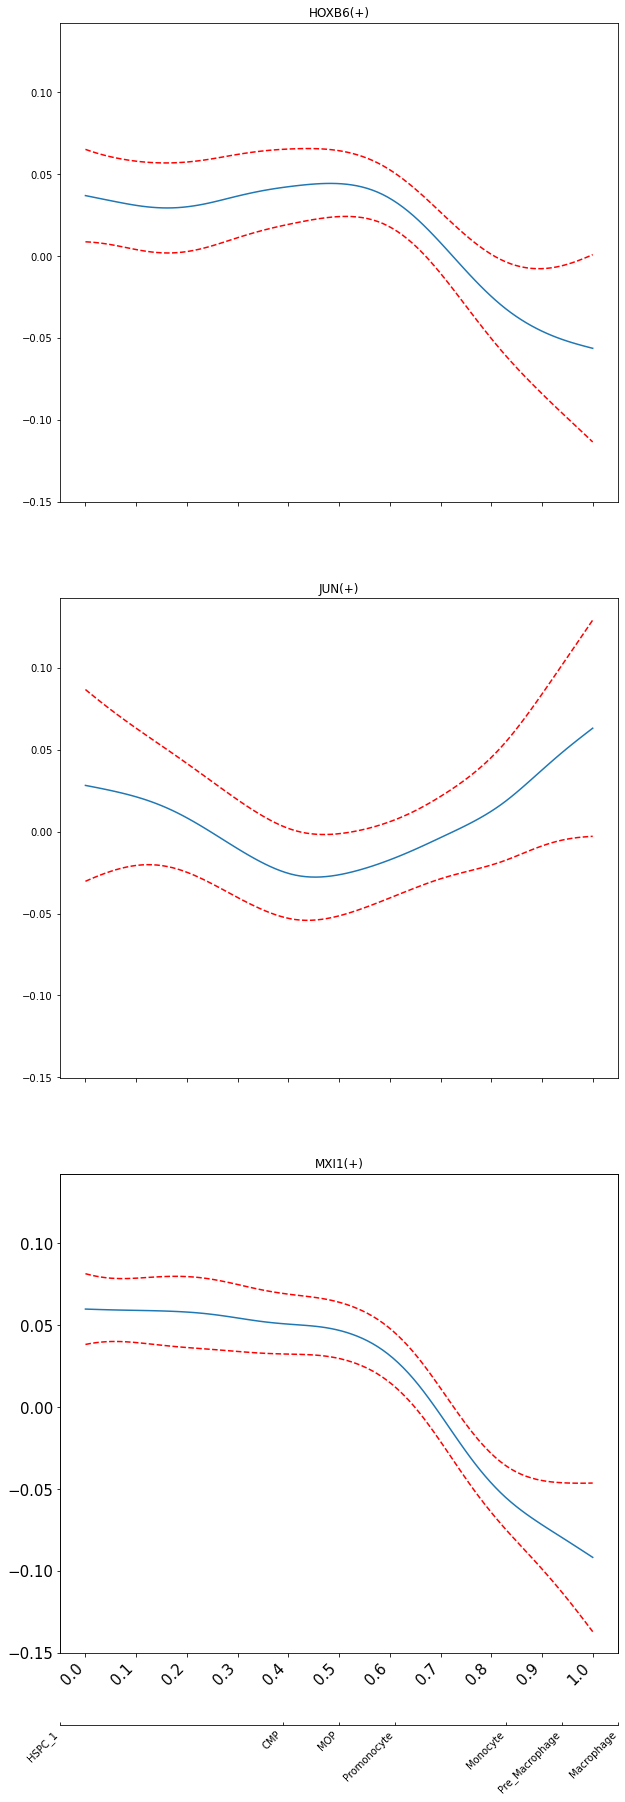

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']

# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(10,10*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name);
        
plt.savefig('./figures/' + lineage +'_hu_top5_intersecting_species_sig_regulons.pdf',dpi=500, bbox_inches="tight")

### MK

In [584]:
adata_hu = sc.read('./data/hu_diff_regulon_aucell.h5ad')
adata_hu_raw = sc.read('./data/hu_diff_regulon.h5ad')

In [585]:
lineage = 'MK'
species = 'hu'

In [586]:
gen_path = './gam_outs/' + lineage + '_' + species + '_'
dat_path = './data/' + lineage + '_' + species + '_'

adata_hu_tmp = sc.read(dat_path + 'lineage_trial_dffimap.h5ad')
# import human_model
import pickle 
filename = gen_path + 'gam.pkl'
with open(filename, 'rb') as f:
    gam1 = pickle.load(f)
data = pd.read_csv(gen_path + 'regulon_dat.csv',index_col=0)
y = pd.read_csv(gen_path +'regulon_psd_time.csv',index_col=0)
gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
sig_gam = pd.read_csv(gen_path +'sig_gam.csv',index_col=0)
homologs = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
X = data
gam_grid = gam1

In [587]:
list(gam_out.index)

['ATF3(+)',
 'ATF5(+)',
 'CEBPA(+)',
 'CEBPD(+)',
 'CREB3L1(+)',
 'CREM(+)',
 'DDIT3(+)',
 'EGR1(+)',
 'EGR2(+)',
 'EGR3(+)',
 'ELF1(+)',
 'ELK1(+)',
 'ELK3(+)',
 'ERG(+)',
 'ETS2(+)',
 'ETV2(+)',
 'FLI1(+)',
 'FOS(+)',
 'FOSB(+)',
 'FOSL2(+)',
 'FOXF1(+)',
 'FOXO3(+)',
 'FOXP1(+)',
 'FOXP2(+)',
 'GATA1(+)',
 'GATA2(+)',
 'GATA3(+)',
 'HOXB6(+)',
 'HOXC9(+)',
 'HSF1(+)',
 'IRF1(+)',
 'IRF7(+)',
 'IRF8(+)',
 'JUN(+)',
 'KLF1(+)',
 'KLF10(+)',
 'KLF2(+)',
 'KLF4(+)',
 'KLF6(+)',
 'MAF(+)',
 'MAFB(+)',
 'MAFF(+)',
 'MEF2C(+)',
 'MSX1(+)',
 'MXI1(+)',
 'MYC(+)',
 'NFATC4(+)',
 'NFE2(+)',
 'NFIA(+)',
 'NFIB(+)',
 'NFIC(+)',
 'NR1H3(+)',
 'NR2F2(+)',
 'REL(+)',
 'RELB(+)',
 'RORA(+)',
 'SOX17(+)',
 'SOX4(+)',
 'SPI1(+)',
 'STAT2(+)',
 'STAT3(+)',
 'TEAD1(+)']

# Plot type 1

<Figure size 432x288 with 0 Axes>

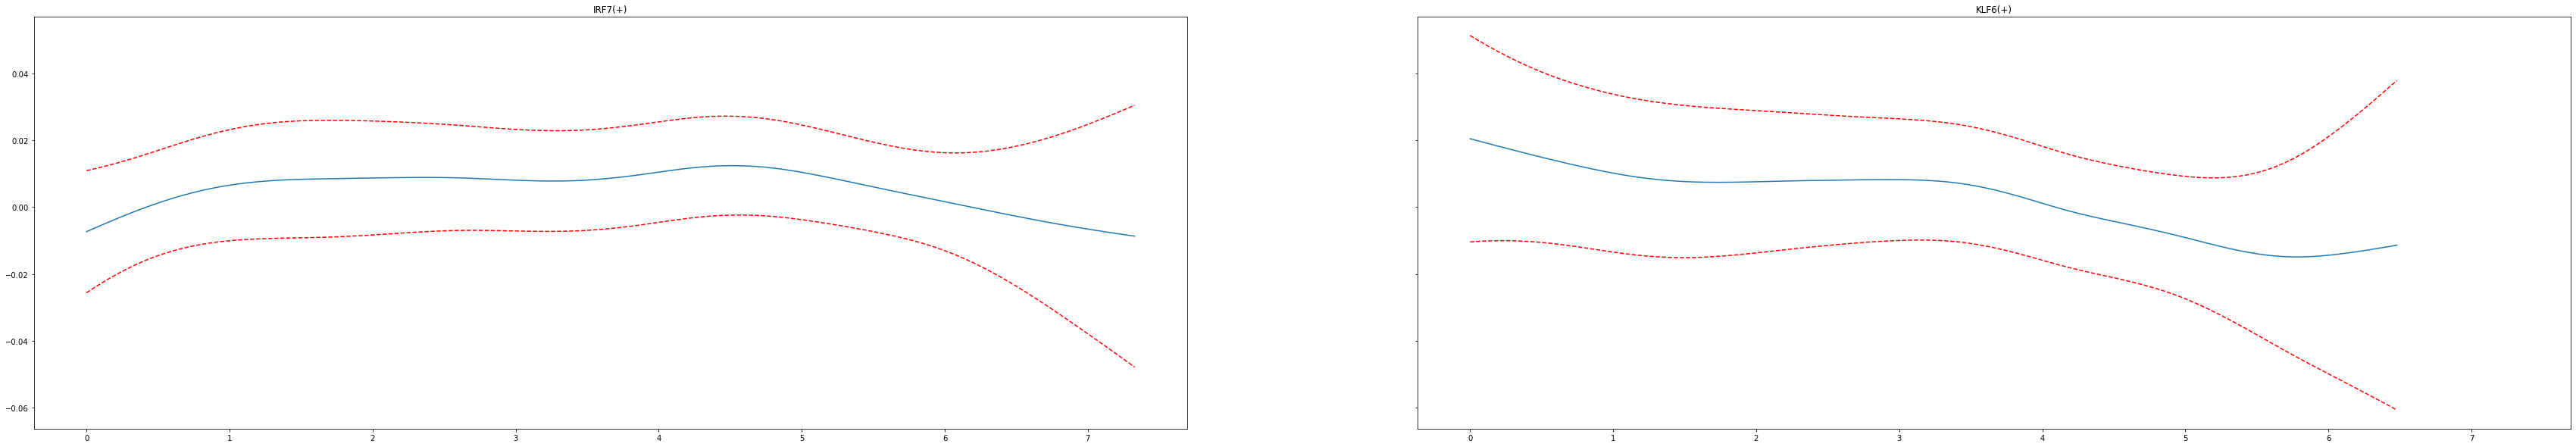

In [588]:
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();
#fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
fig, axs = plt.subplots(1,(dependncies.shape[1]),figsize=(60,10),sharex=True, sharey=True);

for z, ax in enumerate(axs):
    i = int(sig_gam.iloc[z].positions)
    XX = gam1.generate_X_grid(term=i)
    dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    
    #if i == 0:
    #    ax.set_ylim(-30,30)
    #    ax.set_xlim(-30,30)
    ax.set_title(sig_gam.iloc[z].name);
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_tight.pdf',dpi=500, bbox_inches="tight")

# Plot type 2

In [589]:
dpt_pseudotime

[0.0, 0.5, 0.6, 0.8, 1.0]

In [35]:
gam_out['positions']

ATF3(+)        0
CEBPA(+)       1
CREB3L1(+)     2
CREM(+)        3
DDIT3(+)       4
EGR1(+)        5
ELF1(+)        6
ELK1(+)        7
ELK3(+)        8
ERG(+)         9
ETS2(+)       10
ETV2(+)       11
FLI1(+)       12
FOS(+)        13
FOSB(+)       14
FOXO3(+)      15
FOXP1(+)      16
FOXP2(+)      17
GATA1(+)      18
GATA2(+)      19
GATA3(+)      20
HOXB6(+)      21
HOXC9(+)      22
HSF1(+)       23
IRF1(+)       24
JUN(+)        25
KLF1(+)       26
KLF10(+)      27
KLF6(+)       28
MAFF(+)       29
MEF2C(+)      30
MXI1(+)       31
MYC(+)        32
NFE2(+)       33
NFIC(+)       34
NR1H3(+)      35
NR2F2(+)      36
REL(+)        37
RELB(+)       38
RORA(+)       39
SOX4(+)       40
SPI1(+)       41
STAT3(+)      42
Name: positions, dtype: int64

<ipython-input-590-faa64fcadd3c>:14: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


<Figure size 432x288 with 0 Axes>

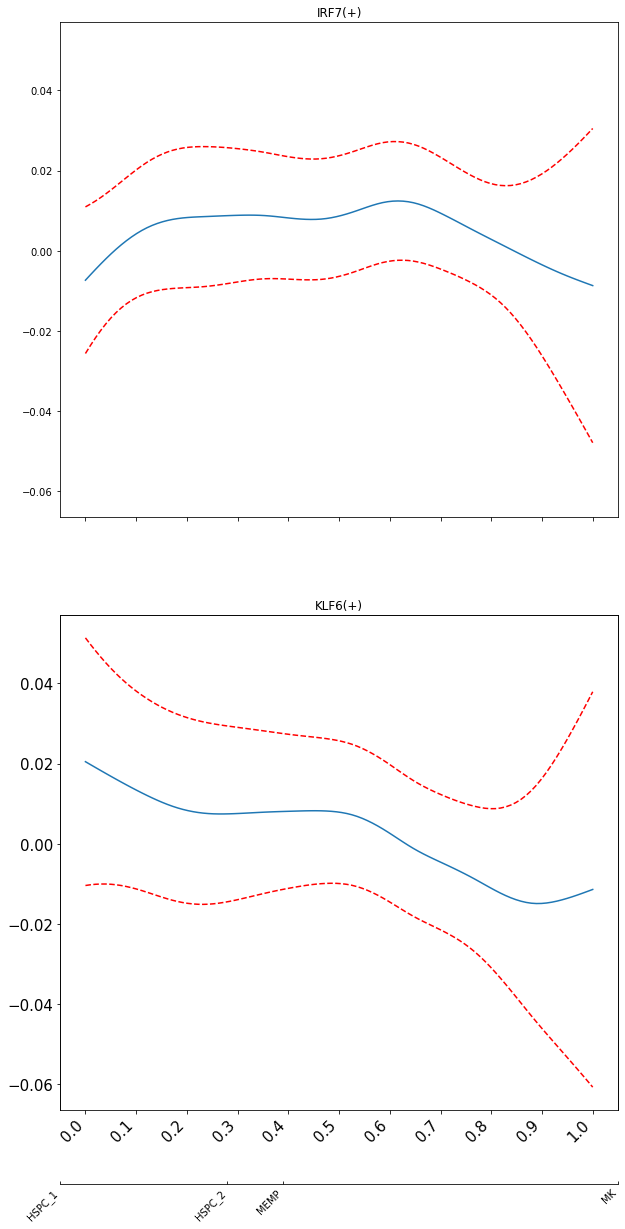

In [590]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
sig_gam = gam_out[gam_out['p_val']<0.05]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))
# # Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    # redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
pseudotime_label_ordering   

# # Round to 2dp
pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
    
    
        #for z, ax in enumerate(axs):
    #    i = int(sig_gam.iloc[z].positions)

    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 

            counter = int(sig_gam.iloc[counter_x].positions)

            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(counter, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
            ax[z].set_title(sig_gam.iloc[counter_x].name)
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])

            counter_x = counter_x + 1
            #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
            #if i == 0:
            #    ax.set_ylim(-30,30)
            #    ax.set_xlim(-30,30)
    
else : 
    
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(10,10*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name);
        

    
plt.savefig('./figures/' + lineage +'_hu_sig_regulons_square_panels.pdf',dpi=500, bbox_inches="tight")

# Plot type 3 top 5 most significant

<ipython-input-591-4a064e95dabc>:33: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


<Figure size 432x288 with 0 Axes>

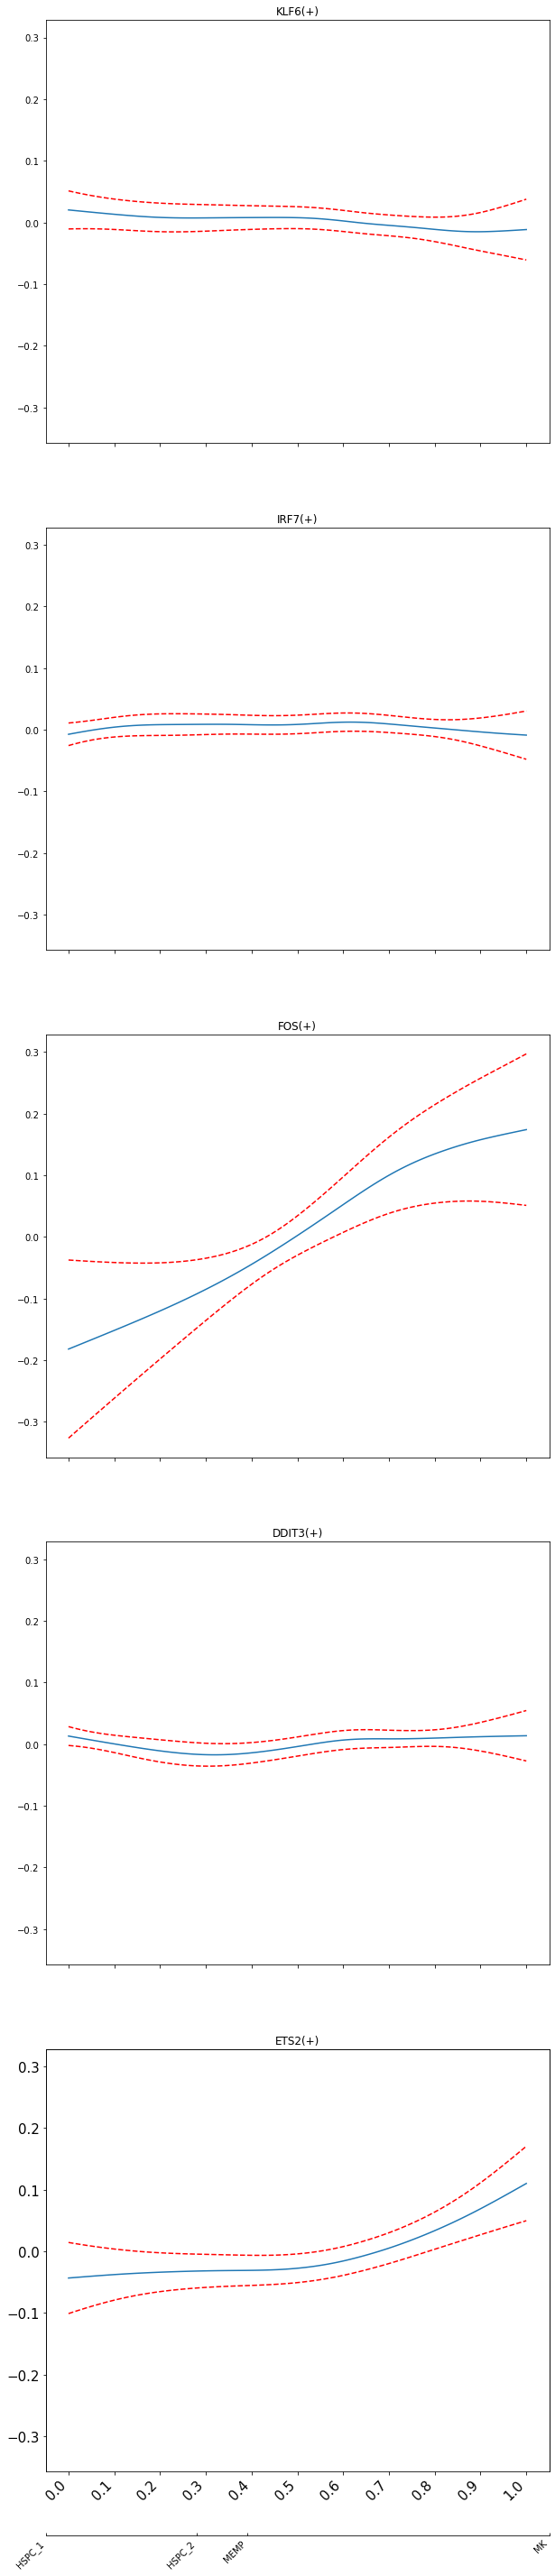

In [591]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
sig_gam = gam_out.nsmallest(5, 'p_val', keep='first')
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']

# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(10,10*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name);
        
plt.savefig('./figures/' + lineage +'_hu_top5_sig_regulons.pdf',dpi=500, bbox_inches="tight")

# Plot type 4 :: Top intersect human and mouse

In [592]:
lineage = lineage
species = 'ms'
gen_path = './gam_outs/' + lineage + '_' + species + '_'
dat_path = './data/' + lineage + '_' + species + '_'
ms_gam_out =  pd.read_csv(gen_path +'gam_outs.csv',index_col=0)
ms_sig_gam = ms_gam_out.nsmallest(10, 'p_val', keep='first')

In [593]:
ms_sig_gam

,p_val
NFE2(+),0.015375
ETS2(+),0.025168
ELK1(+),0.059059
ERG(+),0.107260
ELF1(+),0.125971
GATA3(+),0.155535
CREB3L1(+),0.161875
MAFF(+),0.209239
HOXC9(+),0.209372
KLF10(+),0.217803


In [594]:
hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)].to_csv('./data/'+lineage + '_hu_ms_intersect.csv')
ms_non = ms_sig_gam[~ms_sig_gam.index.isin(hu_sig_gam.index)]
ms_non['species_unique'] = 'ms'
hu_non = hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]
hu_non['species_unique'] = 'hu'
pd.concat([ms_non,hu_non]).to_csv('./data/'+lineage + '_hu_ms_non_intersect.csv')
pd.concat([ms_non,hu_non])

<ipython-input-594-4d143454a721>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ms_non['species_unique'] = 'ms'
<ipython-input-594-4d143454a721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hu_non['species_unique'] = 'hu'


,p_val,species_unique,positions
NFE2(+),1.537515e-02,ms,NaN
ELK1(+),5.905854e-02,ms,NaN
ERG(+),1.072605e-01,ms,NaN
GATA3(+),1.555350e-01,ms,NaN
CREB3L1(+),1.618754e-01,ms,NaN
MAFF(+),2.092387e-01,ms,NaN
HOXC9(+),2.093717e-01,ms,NaN
KLF10(+),2.178034e-01,ms,NaN
CREM(+),6.379404e-07,hu,3.0
DDIT3(+),2.737963e-02,hu,4.0


In [595]:
gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
gam_out['positions'] = list(range(0,len(gam_out)))
hu_sig_gam = gam_out.nsmallest(10, 'p_val', keep='first')

In [596]:
# Check intersect
hu_sig_gam[~hu_sig_gam.index.isin(ms_sig_gam.index)]
hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)]

,p_val,positions
ETS2(+),0.068516,14
ELK1(+),0.076333,11
HOXC9(+),0.087042,28


In [597]:
sig_gam = hu_sig_gam[hu_sig_gam.index.isin(ms_sig_gam.index)]
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]

<ipython-input-598-b9cfa33bb6bf>:27: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))


<Figure size 432x288 with 0 Axes>

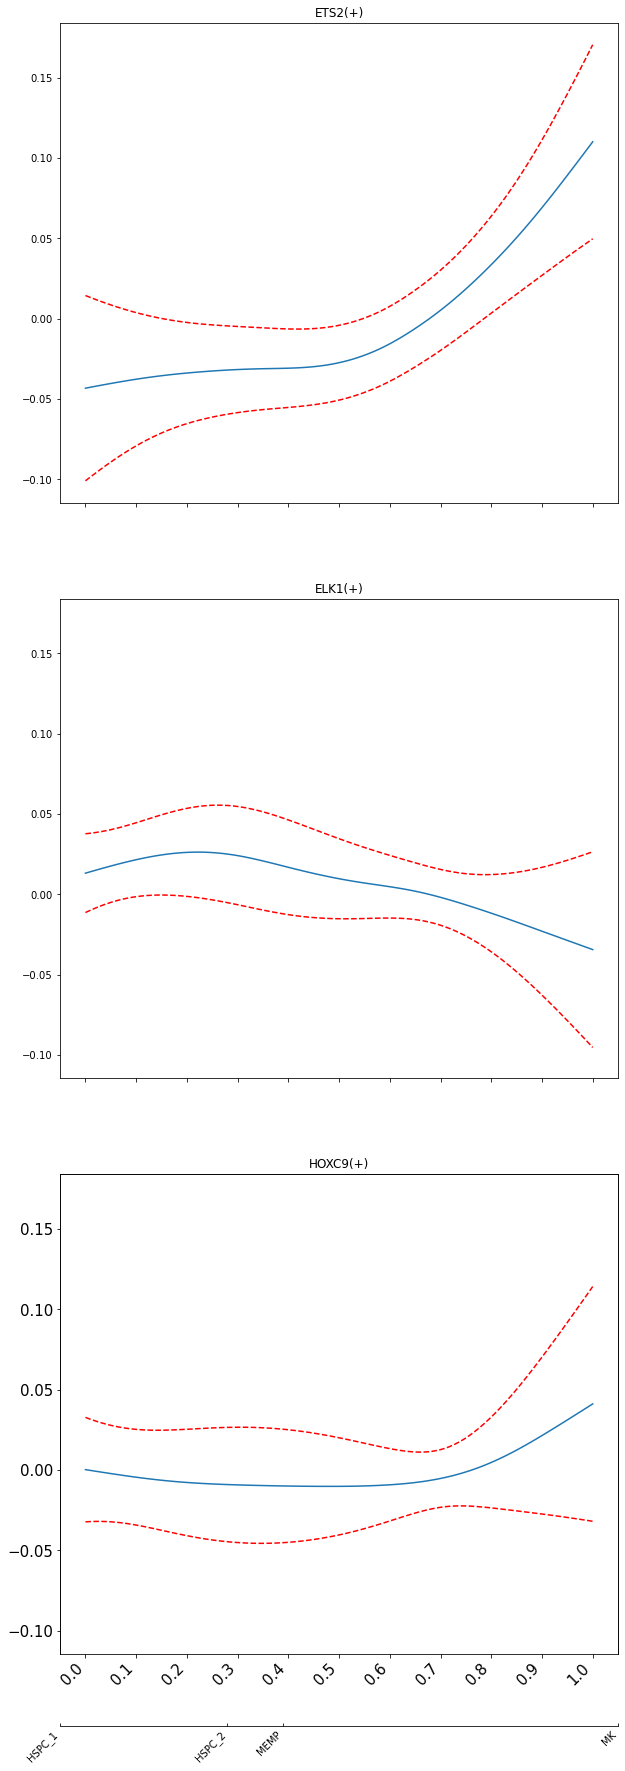

In [598]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# def NormalizeData(data):
#      return (data - np.min(data)) / (np.max(data) - np.min(data))
# # # Order labels along pseudotime by median order value
# pseudotime_label_ordering = adata_ms_tmp.obs.groupby('predicted')[['dpt_pseudotime']].median()
# from scipy import stats
# mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))
# if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
#     # redistribute the data by making the max value the cutoff
#     pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
#     #pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']
# pseudotime_label_ordering   

# # # Round to 2dp
# pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 1) for num in pseudotime_label_ordering['dpt_pseudotime']]
def NormalizeData(data):
     return (data - np.min(data)) / (np.max(data) - np.min(data))

# Order labels along pseudotime by median order value
pseudotime_label_ordering = adata_hu_tmp.obs.groupby('cell.labels')[['dpt_pseudotime']].median()
from scipy import stats
mad_t = (np.median(pseudotime_label_ordering['dpt_pseudotime']) + (2*(stats.median_absolute_deviation(pseudotime_label_ordering['dpt_pseudotime']))))

if (max(pseudotime_label_ordering['dpt_pseudotime']) > mad_t) :
    #redistribute the data by making the max value the cutoff
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] == pseudotime_label_ordering['dpt_pseudotime'][-1],'dpt_pseudotime'] = mad_t
    pseudotime_label_ordering.loc[pseudotime_label_ordering['dpt_pseudotime'] > mad_t,'dpt_pseudotime']

# # # Round to 2dp
# if(len(pseudotime_label_ordering)>2):
#     pseudotime_label_ordering['dpt_pseudotime'] = NormalizeData(pseudotime_label_ordering['dpt_pseudotime'])
# #pseudotime_label_ordering['dpt_pseudotime'] = round(pseudotime_label_ordering['dpt_pseudotime'],2)
# dpt_pseudotime = [round(num, 2) for num in pseudotime_label_ordering['dpt_pseudotime']]    
    
# Dependencies
regulons = sig_gam.index.values
dependncies = X[sig_gam.index.values]
gam1 = gam_grid
plt.figure();

if dependncies.shape[1] > 5:
    grid_shape = 5 * round(dependncies.shape[1]/5)
    fig, axs = plt.subplots(int(grid_shape/5),5,figsize=(30,10*int(grid_shape/5)),sharex=True, sharey=True);
    #fig, axs = plt.subplots((dependncies.shape[1]), sharex=True, sharey=True)
    counter_x = 0
    for i, ax in enumerate(axs):
        for z in range(0,len(ax)): 
            counter = int(sig_gam.iloc[counter_x].positions)
            
            XX = gam1.generate_X_grid(term=counter)
            dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX))
            ax[z].plot( NormalizeData(XX[:, counter]), gam1.partial_dependence(term=counter, X=XX, width=.95)[1], c='r', ls='--')
            ax[z].set_title(regulons[counter])
            ranger = list(range(0,11))
            ranger[:] = [x / 10 for x in ranger]
            #ax[z].set_xticks(ranger, minor=False)

            p , n = list(enumerate(axs))[-1]
            if i == p : 
                ax[z].set_xticks(ranger, minor=False)
                ax[z].tick_params(axis='both', which='major', labelsize=15)
                plt.setp(ax[z].xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
                # only plot second X-axis on bottom row
                ax2 = ax[z].twiny()
                ax2.spines["bottom"].set_position(("axes", -0.15))
                ax2.tick_params('both', length=0, width=0, which='minor')
                ax2.tick_params('both', direction='in', which='major')
                ax2.xaxis.set_ticks_position("bottom")
                ax2.xaxis.set_label_position("bottom")
                # Create upper and lower ticks (annoying but required for the plot)
                #lower, upper = 0.1, 0.9
                #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
                #fixed_locator.insert(0, 0)
                #fixed_locator.insert(len(fixed_locator),1)
                ax2.set_xticks(dpt_pseudotime)
                ax2.xaxis.set_major_formatter(ticker.NullFormatter())
                ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
                ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            else:
                ax[z].set_xticks([])
        
        counter_x = counter_x + 1
        #plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        #if i == 0:
        #    ax.set_ylim(-30,30)
        #    ax.set_xlim(-30,30)
    
    
else : 
    grid_shape = dependncies.shape[1]
    fig, axs = plt.subplots(grid_shape,1,figsize=(10,10*grid_shape),sharex=True, sharey=True);
    
    for z, ax in enumerate(axs):
        i = int(sig_gam.iloc[z].positions)
        XX = gam1.generate_X_grid(term=i)
        dependence = gam1.partial_dependence(i, X=XX, width=None, quantiles=None, meshgrid=False)
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX))
        ax.plot( NormalizeData(XX[:, i]), gam1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        
        p , n = list(enumerate(axs))[-1]
        if z == p : 
            ax.set_xticks(ranger, minor=False)
            ax.tick_params(axis='both', which='major', labelsize=15)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
            # only plot second X-axis on bottom row
            ax2 = ax.twiny()
            ax2.spines["bottom"].set_position(("axes", -0.15))
            ax2.tick_params('both', length=0, width=0, which='minor')
            ax2.tick_params('both', direction='in', which='major')
            ax2.xaxis.set_ticks_position("bottom")
            ax2.xaxis.set_label_position("bottom")
            # Create upper and lower ticks (annoying but required for the plot)
            #lower, upper = 0.1, 0.9
            #fixed_locator = [lower + (upper - lower) * x for x in dpt_pseudotime]
            #fixed_locator.insert(0, 0)
            #fixed_locator.insert(len(fixed_locator),1)
            ax2.set_xticks(dpt_pseudotime)
            ax2.xaxis.set_major_formatter(ticker.NullFormatter())
            ax2.xaxis.set_major_locator(ticker.FixedLocator(dpt_pseudotime))
            ax2.xaxis.set_major_formatter(ticker.FixedFormatter(list(pseudotime_label_ordering.index.values)))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45,ha='right')#ha='center'
        else:
            ax.set_xticks([])
        ax.set_title(sig_gam.iloc[z].name);
        
plt.savefig('./figures/' + lineage +'_hu_top5_intersecting_species_sig_regulons.pdf',dpi=500, bbox_inches="tight")